# Neural Collaborative Based Filtering

- using neural network to learn the user-item interaction

This piece is a TensorFlow implementation of Neural Collaborative Filtering (NCF) from the paper [He et al. (2017)](https://arxiv.org/pdf/1708.05031.pdf).

## Summary

NCF uses neural networks to model the interactions between users and items. NCF replaces the inner product (used in ordinary MF methods) with a neural architecture that can learn an arbitrary function from data. This allows NCF to express and generalize matrix factorization under its framework. Essentially, it uses a neural network to learn the user-item interaction function, and uses the learned function to predict the corresponding rating. A multi-layer perceptron is used to learn the user-item interaction function. 


## Model 1: Ratings Only

The steps are as follows:

1. Read in Original Data
2. Remove some ratings to create the test set
3. With remaining ratings, create training set
4. Preprocess the data (melt the data, create user and item indices, normalize the ratings)
5. Create neural network model (NCF)
6. Train the model
7. Hyperparameter tuning
8. Evaluate the model on the test set
9. Gather all ratings prediction metrics (MAE, MSE, RMSE)

In [1]:
# reset space
%reset -f

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# tensorflow libraries load
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


2024-04-01 20:08:38.920181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/pavansingh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# load data
# amz_data = pd.read_csv(r'C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\Data\set2_data_modelling.csv')
amz_data = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/set3_data_modelling.csv')
display(amz_data.head())

# print details
print('Number of Rows: ', amz_data.shape[0])
print('Number of Columns: ', amz_data.shape[1])
print('Number of Unique Users: ', len(amz_data['reviewerID'].unique()))
print('Number of Unique Products: ', len(amz_data['asin'].unique()))
print('Min number of ratings per user: ', amz_data['reviewerID'].value_counts().min())
print('Max number of ratings per user: ', amz_data['reviewerID'].value_counts().max())
print('Min number of ratings per product: ', amz_data['asin'].value_counts().min())
print('Max number of ratings per product: ', amz_data['asin'].value_counts().max())



# Creating User Item Matrix =====================================================
# create user-item matrix
data = amz_data.pivot_table(index='reviewerID', columns='asin', values='overall')
print("\n\nUser-Item Matrix")
display(data.head())


,reviewerID,reviewTime,asin,overall,reviewText,stemmed_words_revText,lemmatised_reviewText,filtered_tokens_revText,sentiments_afinn,sentiments_bing,sentiments_vader
0,AQ8OO59DJFJNZ,2018-01-05,0767834739,5.0,wonderful movie,wonder movi,wonderful movie,wonderful movie,4,1,0.5719
1,A244CRJ2QSVLZ4,2008-01-29,0767834739,5.0,resident evil is a great science fictionhorror...,resid evil great scienc fictionhorror hybrid p...,resident evil great science fictionhorror hybr...,resident evil great science fictionhorror hybr...,-12,-5,-0.9455
2,A1VCLTAGM5RLND,2005-07-23,0767834739,5.0,i this movie has people living and working und...,movi peopl live work underground place call hi...,movie people living working underground place ...,movie people living working underground place ...,-1,0,-0.1806
3,A119Q9NFGVOEJZ,2016-02-13,0767834739,5.0,every single video game based movie from the s...,everi singl video game base movi super mario b...,every single video game based movie super mari...,every single video game based movie super mari...,18,6,0.9846
4,A1RP6YCOS5VJ5I,2006-09-26,0767834739,5.0,i think that i like this movie more than the o...,think like movi origin origin still great real...,think like movie original original still great...,think like movie original original still great...,29,10,0.9951


Number of Rows:  83139
Number of Columns:  11
Number of Unique Users:  3668
Number of Unique Products:  3249
Min number of ratings per user:  13
Max number of ratings per user:  193
Min number of ratings per product:  13
Max number of ratings per product:  189


User-Item Matrix


asin,0767834739,7799146915,B00000DMAT,B00000DMAX,B00000DMB3,B00000F1GM,B00000I1BJ,B00000I1BY,B00000ID61,B00000INR2,...,B01H353FLA,B01H353HUY,B01H3VFR6U,B01H5GB8ZW,B01H6OXQFS,B01H9SH2LU,B01HGBAFNC,B01HHVVLGQ,B01HHVWWMI,B01HIZF7XE
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100RH4M1W1DF0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
A1027EV8A9PV1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103KKI1Y4TFNQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1047P9FLHTDZJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating Train and Test Sets

In [3]:
# DATA PREP ====================================

# create a copy of the original matrix to store hidden ratings
x_hidden = data.copy()
indices_tracker = []

# number of products to hide for each user
N = 3

# identifies rated items and randomly selects N products to hide ratings for each user
np.random.seed(2207)  # You can use any integer value as the seed
for user_id in range(x_hidden.shape[0]):
    rated_products = np.where(x_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_products, N, replace=False)
    indices_tracker.append(hidden_indices)
    x_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = x_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'product', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = x_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='product', value_name='rating')

# change rows with hidden ratings to NaN
data_hidden.iloc[indices_hidden, 2] = np.nan

# rename columns
data_hidden.columns = ['user', 'product', 'rating']

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# Convert user and item to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['product'] = data_hidden['product'].astype('category')

# see what the data looks like
display(data_hidden.head(4))
print("Data is in format: user, product, rating.\nIt is ready to be partitioned into training and testing sets.")

,user,product,rating
24,A119Q9NFGVOEJZ,0767834739,5.0
39,A120UTHQDQIJGH,0767834739,1.0
157,A169I83JL8QJGN,0767834739,1.0
333,A1COW0UIB5HA9J,0767834739,5.0


Data is in format: user, product, rating.
It is ready to be partitioned into training and testing sets.


In [ ]:
# # validation data (take 2 more random ratings)
# x_validation = data_hidden.copy()
# indices_tracker_val = []

# # number of products to hide for each user
# N = 2

# # identifies rated items and randomly selects N products to hide ratings for each user
# np.random.seed(2207)  # You can use any integer value as the seed
# for user_id in range(x_validation.shape[0]):
#     rated_products = np.where(x_validation.iloc[user_id, :] > 0)[0]
#     hidden_indices = np.random.choice(rated_products, N, replace=False)
#     indices_tracker_val.append(hidden_indices)
#     x_validation.iloc[user_id, hidden_indices] = 'Hidden'

# # get indices of hidden ratings
# val_data = x_validation.copy()
# val_data = val_data.reset_index()
# val_data = val_data.melt(id_vars=val_data.columns[0], var_name='book', value_name='rating')
# val_data.columns = ['user', 'product', 'rating']
# indices_hidden_val = val_data[val_data['rating'] == 'Hidden'].index

# # Melt the DataFrame into a format where each row is a user-item interaction
# data_hidden_val = x_validation.reset_index()
# data_hidden_val = data_hidden_val.melt(id_vars=data_hidden_val.columns[0], var_name='product', value_name='rating')

In [4]:
# TEST AND TRAIN DATA ====================================

# Prepare the data - trining
train_x = data_hidden[['user', 'product']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='product', value_name='rating')
copy.columns = ['user', 'product', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]
test_x['user'] = test_x['user'].astype('category')
test_x['product'] = test_x['product'].astype('category')
test_x = test_x.apply(lambda x: x.cat.codes)
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

# show the data
print("Training Data")
display(train_x.head(3))

print("\nTesting Data")
display(test_x.head(3))

Training Data


,user,product
24,24,0
39,39,0
157,157,0



Testing Data


,user,product
174,174,0
4473,805,1
4869,1201,1


### Creating NCF Model

Inputs:
user_input and product_input: These are integer inputs representing user and product IDs.
user_embedding and product_embedding: These layers create dense embeddings for users and products based on their IDs.
user_vecs and product_vecs: These flatten the embeddings to create feature vectors.
input_vecs: The concatenated feature vectors serve as the input to the neural network.
Neural Network Architecture:
You’ve designed a feedforward neural network with multiple layers.
The first layer (i == 0) has n_nodes neurons, followed by dropout regularization.
Subsequent layers reduce the number of neurons by halving n_nodes.
The final output layer predicts the rating (regression task).
Optimizers:
You’ve implemented three optimizers: Adam, SGD, and RMSprop.
The choice of optimizer affects how the model updates its weights during training.
Loss Function:
The mean squared error (MSE) loss is used for regression tasks.
The model aims to minimize the difference between predicted and actual ratings.
Training:
The model is trained using user and product IDs as input features.
The train_x dictionary contains user and product data.
The train_y array holds the corresponding ratings.
You’ve split the data into training and validation sets (10% validation split).

In [5]:
# Function to train a neural network model for collaborative filtering
def train_model_1(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2_reg, train_x, train_y, seed=2207, train_plot=True, callback=True):
    
    # Set random seed
    np.random.seed(seed)

    # Create user and product embedding layers
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')

    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    product_embedding = Embedding(input_dim=len(data_hidden['product'].cat.categories), output_dim=50, name='product_embedding')(product_input)

    # Flatten the embedding vectors
    user_vecs = Flatten()(user_embedding)
    product_vecs = Flatten()(product_embedding)

    # Concatenate the embedding vectors
    input_vecs = Concatenate()([user_vecs, product_vecs])

    # Add dense layers
    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu', kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu', kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout)(x)
    y = Dense(1)(x)

    # Compile the model
    model = Model(inputs=[user_input, product_input], outputs=y)
    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    # Define early stopping
    if callback:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Train the model
    if callback:
        history = model.fit([train_x['user'], train_x['product']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])
    else:
        history = model.fit([train_x['user'], train_x['product']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    if train_plot:
        # Plot training & validation loss values
        plt.figure(figsize=(15, 8))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        # plt.title(f'Model loss for Architecture: {optimizer} optimizer, {n_layers} layers, {n_nodes} nodes, {epochs} epochs, {learning_rate} learning rate, {batch_size} batch size')
        plt.ylabel('Loss', fontsize=40)
        plt.xlabel('Epoch', fontsize = 40)
        plt.xticks(fontsize=36)
        plt.yticks(fontsize=36)
        plt.tight_layout()
        plt.savefig("/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Final Writing/Figures/ncf_training_1.pdf")
        plt.show()
    
    return model, history

### Training NCF Model

- increasing batch size is good:128
- increase nodes
- change optimizer
- change learning rate

In [ ]:
# # model with validation data
# model, history = train_model_1(n_layers=2, n_nodes=64, optimizer='adam', epochs=100, learning_rate=0.001, batch_size=64, dropout=0.2, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=2207, train_plot=True, callback=True, validation_data=True)

In [6]:
# Model 1 
model, history = train_model_1(n_layers=2, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=128, dropout=0.5, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=10, train_plot=False, callback=True)

# # Model 2 
model2, history2 = train_model_1(n_layers=3, n_nodes=1024, optimizer='sgd', epochs=1000, learning_rate=0.001, batch_size=128, dropout=0.5, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=10, train_plot=False, callback=True)

# # Model 3 
model3, history3 = train_model_1(n_layers=3, n_nodes=1024, optimizer='rmsprop', epochs=200, learning_rate=0.001, batch_size=128, dropout=0.5, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=10, train_plot=False, callback=True)

# # Model 4
model4, history4 = train_model_1(n_layers=8, n_nodes=1024, optimizer='adam', epochs=450, learning_rate=0.001, batch_size=128, dropout=0.5, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=10, train_plot=False, callback=True)

# # Model 5 
model5, history5 = train_model_1(n_layers=12, n_nodes=2048, optimizer='sgd', epochs=1000, learning_rate=0.001, batch_size=128, dropout=0.5, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=10, train_plot=False, callback=True)

Epoch 1/50
508/508 [==============================] - 6s 9ms/step - loss: 0.3595 - val_loss: 0.0554
Epoch 2/50
508/508 [==============================] - 4s 8ms/step - loss: 0.0564 - val_loss: 0.0545
Epoch 3/50
508/508 [==============================] - 4s 8ms/step - loss: 0.0512 - val_loss: 0.0506
Epoch 4/50
508/508 [==============================] - 4s 9ms/step - loss: 0.0485 - val_loss: 0.0513
Epoch 5/50
508/508 [==============================] - 4s 8ms/step - loss: 0.0468 - val_loss: 0.0504
Epoch 6/50
508/508 [==============================] - 5s 9ms/step - loss: 0.0455 - val_loss: 0.0504
Epoch 7/50
508/508 [==============================] - 5s 10ms/step - loss: 0.0444 - val_loss: 0.0501
Epoch 8/50
508/508 [==============================] - 4s 9ms/step - loss: 0.0438 - val_loss: 0.0502
Epoch 9/50
508/508 [==============================] - 5s 9ms/step - loss: 0.0429 - val_loss: 0.0498
Epoch 10/50
508/508 [==============================] - 4s 7ms/step - loss: 0.0423 - val_loss: 0.050

In [8]:
# Which model had lowest validation loss?
print("Model 1 Validation Loss: ", min(history.history['val_loss']))
print("Model 2 Validation Loss: ", min(history2.history['val_loss']))
print("Model 3 Validation Loss: ", min(history3.history['val_loss']))
print("Model 4 Validation Loss: ", min(history4.history['val_loss']))
print("Model 5 Validation Loss: ", min(history5.history['val_loss']))

Model 1 Validation Loss:  0.05599576607346535
Model 2 Validation Loss:  0.05603745952248573
Model 3 Validation Loss:  0.05599360913038254
Model 4 Validation Loss:  0.05599367618560791
Model 5 Validation Loss:  0.05602634325623512


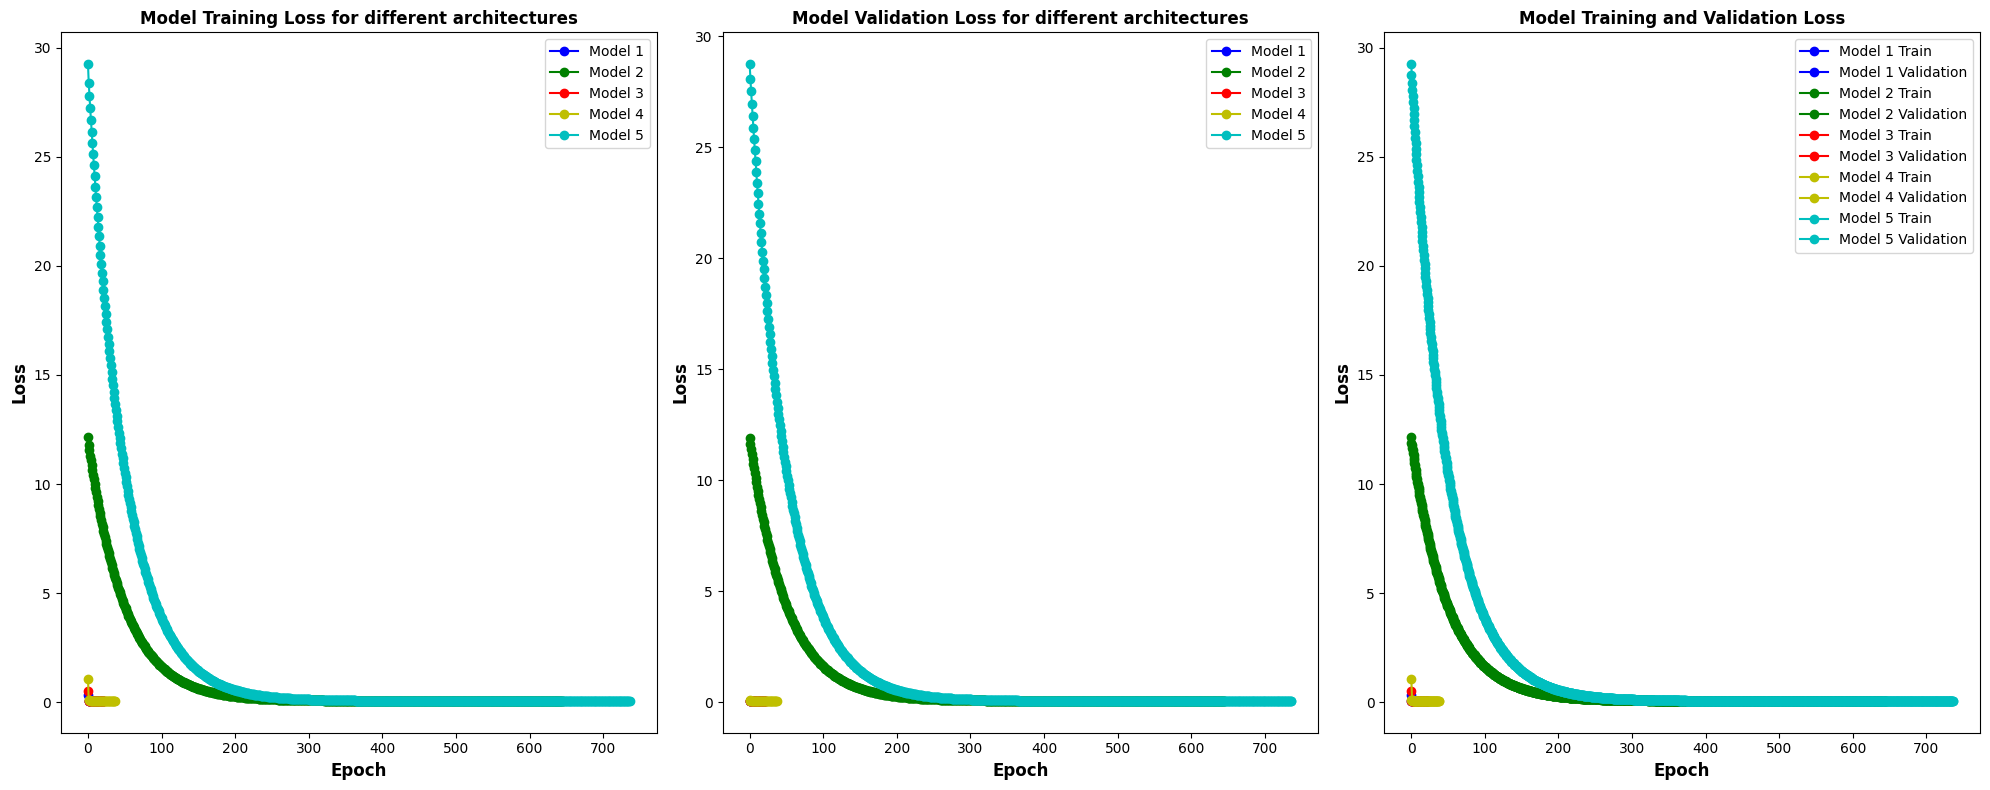

In [10]:
# Visualize training and validation loss for all models
plt.figure(figsize=(20, 8))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4', marker='o', color = 'y')
plt.plot(history5.history['loss'], label='Model 5', marker='o', color = 'c')
plt.title('Model Training Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Validation Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['val_loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['val_loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['val_loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['val_loss'], label='Model 4', marker='o', color = 'y')
plt.plot(history5.history['val_loss'], label='Model 5', marker='o', color = 'c')
plt.title('Model Validation Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Plot validation and training loss on same plot
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Model 1 Train', marker='o', color = 'b')
plt.plot(history.history['val_loss'], label='Model 1 Validation', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2 Train', marker='o', color = 'g')
plt.plot(history2.history['val_loss'], label='Model 2 Validation', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3 Train', marker='o', color = 'r')
plt.plot(history3.history['val_loss'], label='Model 3 Validation', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4 Train', marker='o', color = 'y')
plt.plot(history4.history['val_loss'], label='Model 4 Validation', marker='o', color = 'y')
plt.plot(history5.history['loss'], label='Model 5 Train', marker='o', color = 'c')
plt.plot(history5.history['val_loss'], label='Model 5 Validation', marker='o', color = 'c')
plt.title('Model Training and Validation Loss', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print models details

### Hyperparameter Tuning / Grid Search

In [ ]:
import itertools

# Grid Search Parameters
n_layers = [1,2,3,6,8] 
n_nodes = [128,256,512,1024] 
optimizer = ['adam', 'sgd']
epochs = [50,150,300] 
learning_rate = [0.001, 0.01,  0.0001] 
batch_size = [32,64,128] 
dropout = [0, 0.01, 0.05, 0.08]
l2 = [0.01, 0.001, 0.0001]

print(f"Number of combinations: {len(n_layers) * len(n_nodes) * len(optimizer) * len(epochs) * len(learning_rate) * len(batch_size)* len(dropout)* len(l2)}")

def grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2, train_x, train_y):
    # Initialize best parameters and best model variables
    best_params = None
    best_model = None
    best_score = None

    # Generate all possible combinations of hyperparameters
    param_combinations = itertools.product(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2)

    # Loop through all combinations
    for combination in param_combinations:
        # Unpack the combination
        n_layer, n_node, opt, epoch, lr, bs, dropout, l2 = combination

        # Train the model
        model, history = train_model_1(n_layer, n_node, opt, epoch, lr, bs, dropout, l2, train_x, train_y, seed=10, train_plot=False, callback=True)

        # Evaluate the model
        min_loss = min(history.history['val_loss'])

        # Check if this model is better than the previous best
        if best_score is None or min_loss < best_score:
            best_score = min_loss
            best_params = combination
            best_model = model

    return best_params, best_model


# run grid search
best_params, best_model = grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2, train_x, train_y)
print(f"Best Parameters: {best_params}")

Epoch 1/50
508/508 [==============================] - 4s 6ms/step - loss: 0.3333 - val_loss: 0.0560
Epoch 2/50
508/508 [==============================] - 3s 5ms/step - loss: 0.0603 - val_loss: 0.0537
Epoch 3/50
508/508 [==============================] - 3s 5ms/step - loss: 0.0536 - val_loss: 0.0514
Epoch 4/50
508/508 [==============================] - 3s 5ms/step - loss: 0.0498 - val_loss: 0.0499
Epoch 5/50
508/508 [==============================] - 3s 5ms/step - loss: 0.0476 - val_loss: 0.0497
Epoch 6/50
508/508 [==============================] - 3s 6ms/step - loss: 0.0458 - val_loss: 0.0499
Epoch 7/50
508/508 [==============================] - 3s 5ms/step - loss: 0.0446 - val_loss: 0.0498
Epoch 8/50
508/508 [==============================] - 3s 5ms/step - loss: 0.0437 - val_loss: 0.0499
Epoch 9/50
508/508 [==============================] - 3s 5ms/step - loss: 0.0431 - val_loss: 0.0490
Epoch 10/50
508/508 [==============================] - 3s 5ms/step - loss: 0.0429 - val_loss: 0.0488

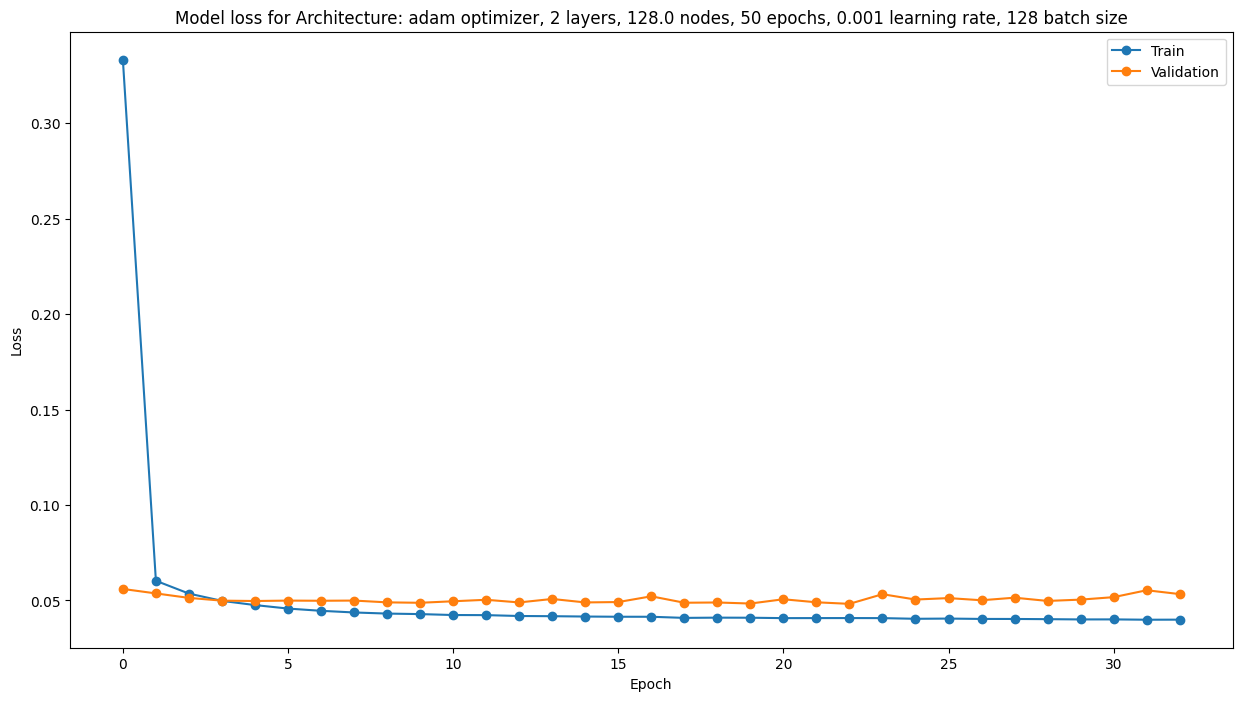

In [19]:
# fit best model 
best_model, history = train_model_1(n_layers=best_params[0], n_nodes=best_params[1], optimizer=best_params[2], epochs=best_params[3], learning_rate=best_params[4], batch_size=best_params[5], dropout=best_params[6], l2_reg=best_params[7], train_x=train_x, train_y=train_y, train_plot=True, callback=True, seed=10)

### Evaluating NCF Model

In [7]:
# MODEL EVALUATION ====================================
# Predict the ratings
# y_pred = best_model.predict([test_x['user'], test_x['product']])
y_pred = model.predict([test_x['user'], test_x['product']])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# save results to csv
results = pd.DataFrame({'MAE': [mae.round(3)], 'MSE': [mse.round(3)], 'RMSE': [rmse.round(3)]})
# results.to_csv(r"/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/Results/NCF_results_1.csv", index=False)
results.index = ['NCF']
results

344/344 [==============================] - 1s 2ms/step

Rating Metrics
Mean Absolute Error (MAE): 0.6146627988697442
Mean Squared Error (MSE): 0.8335727036341247
Root Mean Squared Error (RMSE): 0.9130020282749238


,MAE,MSE,RMSE
NCF,0.615,0.834,0.913


### Additional Accuracy Insights

1. Want to see if accuracy is better for users who have rated more items. (i.e., for users who have rated more items, is the accuracy of the model better?)

2. Want to see if accuracy is better for items that have been rated more times. (i.e., for items that have been rated more times, is the accuracy of the model better?)

3. Want to see if accuracy is better for some product categories. (i.e., for some product categories, is the accuracy of the model better?)
- TOO FEW REVIEWS PER CATEGORY
- RESULTS WOULD NOT OFFER MUCH INSIGHT

4. Want to see if accuracy is better for reviews that are longer. (i.e., for reviews that are longer, is the accuracy of the model better?)


Effectively, we want to see if accuracy varies according to some variables X or Y.

In [56]:
###### QUESTION 1: PROCESS
# 1. Group Users by the Number of Rated Items: Count the number of rated items for each user in your dataset.

# Count the number of rated items for each user
user_ratings = train_x.groupby('user')['product'].count().reset_index()
user_ratings.columns = ['user', 'n_rated_items']

# 2. Divide Users into Groups: Divide users into groups based on the number of rated items. You can define these groups based on quartiles, for example, or any other criteria that make sense for your dataset.

# Divide users into groups based on the number of rated items
user_ratings['group'] = pd.qcut(user_ratings['n_rated_items'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
display(user_ratings)

# what are the number of users in each group?
print(f'Number of Users in Low Group: {user_ratings[user_ratings["group"] == "Low"].shape[0]}')
print(f'Number of Users in Medium Group: {user_ratings[user_ratings["group"] == "Medium"].shape[0]}')
print(f'Number of Users in High Group: {user_ratings[user_ratings["group"] == "High"].shape[0]}')
print(f'Number of Users in Very High Group: {user_ratings[user_ratings["group"] == "Very High"].shape[0]}')

# 3. Evaluate the Model for Each Group: Evaluate the model for each group of users. You can use the same metrics you used in the previous question.
low_group = user_ratings[user_ratings['group'] == 'Low']
medium_group = user_ratings[user_ratings['group'] == 'Medium']
high_group = user_ratings[user_ratings['group'] == 'High']
very_high_group = user_ratings[user_ratings['group'] == 'Very High']

# get test set items for these groups
low_group_test = test_x[test_x['user'].isin(low_group['user'])]
medium_group_test = test_x[test_x['user'].isin(medium_group['user'])]
high_group_test = test_x[test_x['user'].isin(high_group['user'])]
very_high_group_test = test_x[test_x['user'].isin(very_high_group['user'])]

# get test set ratings for these groups
low_group_ratings = test_y[test_x['user'].isin(low_group['user'])]
medium_group_ratings = test_y[test_x['user'].isin(medium_group['user'])]
high_group_ratings = test_y[test_x['user'].isin(high_group['user'])]
very_high_group_ratings = test_y[test_x['user'].isin(very_high_group['user'])]

# get predictions for these groups
low_group_pred = y_pred[test_x['user'].isin(low_group['user'])]
medium_group_pred = y_pred[test_x['user'].isin(medium_group['user'])]
high_group_pred = y_pred[test_x['user'].isin(high_group['user'])]
very_high_group_pred = y_pred[test_x['user'].isin(very_high_group['user'])]

# set predictions and actual ratings to variables
low_group_ratings_array = (np.array(low_group_ratings)*4 + 1)
low_group_pred_array = np.array(low_group_pred).flatten()

medium_group_ratings_array = (np.array(medium_group_ratings)*4 + 1)
medium_group_pred_array = np.array(medium_group_pred).flatten()

high_group_ratings_array = (np.array(high_group_ratings)*4 + 1)
high_group_pred_array = np.array(high_group_pred).flatten()

very_high_group_ratings_array = (np.array(very_high_group_ratings)*4 + 1)
very_high_group_pred_array = np.array(very_high_group_pred).flatten()

# Rating predictions
low_group_mae = mean_absolute_error(low_group_ratings_array, low_group_pred_array)
low_group_mse = mean_squared_error(low_group_ratings_array, low_group_pred_array)
low_group_rmse = np.sqrt(low_group_mse)

medium_group_mae = mean_absolute_error(medium_group_ratings_array, medium_group_pred_array)
medium_group_mse = mean_squared_error(medium_group_ratings_array, medium_group_pred_array)
medium_group_rmse = np.sqrt(medium_group_mse)

high_group_mae = mean_absolute_error(high_group_ratings_array, high_group_pred_array)
high_group_mse = mean_squared_error(high_group_ratings_array, high_group_pred_array)    
high_group_rmse = np.sqrt(high_group_mse)

very_high_group_mae = mean_absolute_error(very_high_group_ratings_array, very_high_group_pred_array)
very_high_group_mse = mean_squared_error(very_high_group_ratings_array, very_high_group_pred_array)
very_high_group_rmse = np.sqrt(very_high_group_mse)

# display results
print("Checking if the number of reviews impact the model performance.")
results = pd.DataFrame({'MAE': [low_group_mae.round(3), medium_group_mae.round(3), high_group_mae.round(3), very_high_group_mae.round(3)], 'MSE': [low_group_mse.round(3), medium_group_mse.round(3), high_group_mse.round(3), very_high_group_mse.round(3)], 'RMSE': [low_group_rmse.round(3), medium_group_rmse.round(3), high_group_rmse.round(3), very_high_group_rmse.round(3)]})
results.index = ['Low', 'Medium', 'High', 'Very High']
print(f'Number of Users in Low Group: {low_group.shape[0]}')
print(f'Number of Users in Medium Group: {medium_group.shape[0]}')
print(f'Number of Users in High Group: {high_group.shape[0]}')
print(f'Number of Users in Very High Group: {very_high_group.shape[0]}')
results


,user,n_rated_items
0,0,37
1,1,43
2,2,15
3,3,37
4,4,14
...,...,...
3663,3663,31
3664,3664,11
3665,3665,12
3666,3666,19


In [58]:
# evaluate the performance of model for each user
for user in range(user_ratings.shape[0]):
    user = user_ratings['user'][user]
    # get test set items for user
    user_test = test_x[test_x['user'] == user]
    # get test set ratings for user
    users_ratings = test_y[test_x['user'] == user]
    # get predictions for user
    user_pred = y_pred[test_x['user'] == user]
    # set predictions and actual ratings to variables
    user_ratings_array = (np.array(users_ratings)*4 + 1)
    user_pred_array = np.array(user_pred).flatten()
    # Rating predictions
    user_mae = mean_absolute_error(user_ratings_array, user_pred_array)
    user_mse = mean_squared_error(user_ratings_array, user_pred_array)
    user_rmse = np.sqrt(user_mse)
    # assing results to user_ratings
    user_ratings.loc[user, 'MAE'] = user_mae
    user_ratings.loc[user, 'MSE'] = user_mse
    user_ratings.loc[user, 'RMSE'] = user_rmse

Checking if the number of reviews impact the model performance.
Number of Users in Low Group: 1271
Number of Users in Medium Group: 720
Number of Users in High Group: 764
Number of Users in Very High Group: 913


,MAE,MSE,RMSE
Low,0.621,0.855,0.925
Medium,0.582,0.763,0.873
High,0.648,0.904,0.951
Very High,0.638,0.857,0.926


In [62]:
user_ratings

,user,n_rated_items,group,MAE,MSE,RMSE
0,0,37,Very High,0.707349,1.189122,1.090469
1,1,43,Very High,0.668188,0.478164,0.691494
2,2,15,Medium,0.386728,0.208758,0.456901
3,3,37,Very High,0.510734,0.337426,0.580884
4,4,14,Medium,0.157828,0.027472,0.165747
...,...,...,...,...,...,...
3663,3663,31,Very High,0.374515,0.269590,0.519220
3664,3664,11,Low,1.527730,2.506236,1.583110
3665,3665,12,Low,0.919193,0.891832,0.944368
3666,3666,19,High,0.115957,0.013450,0.115973


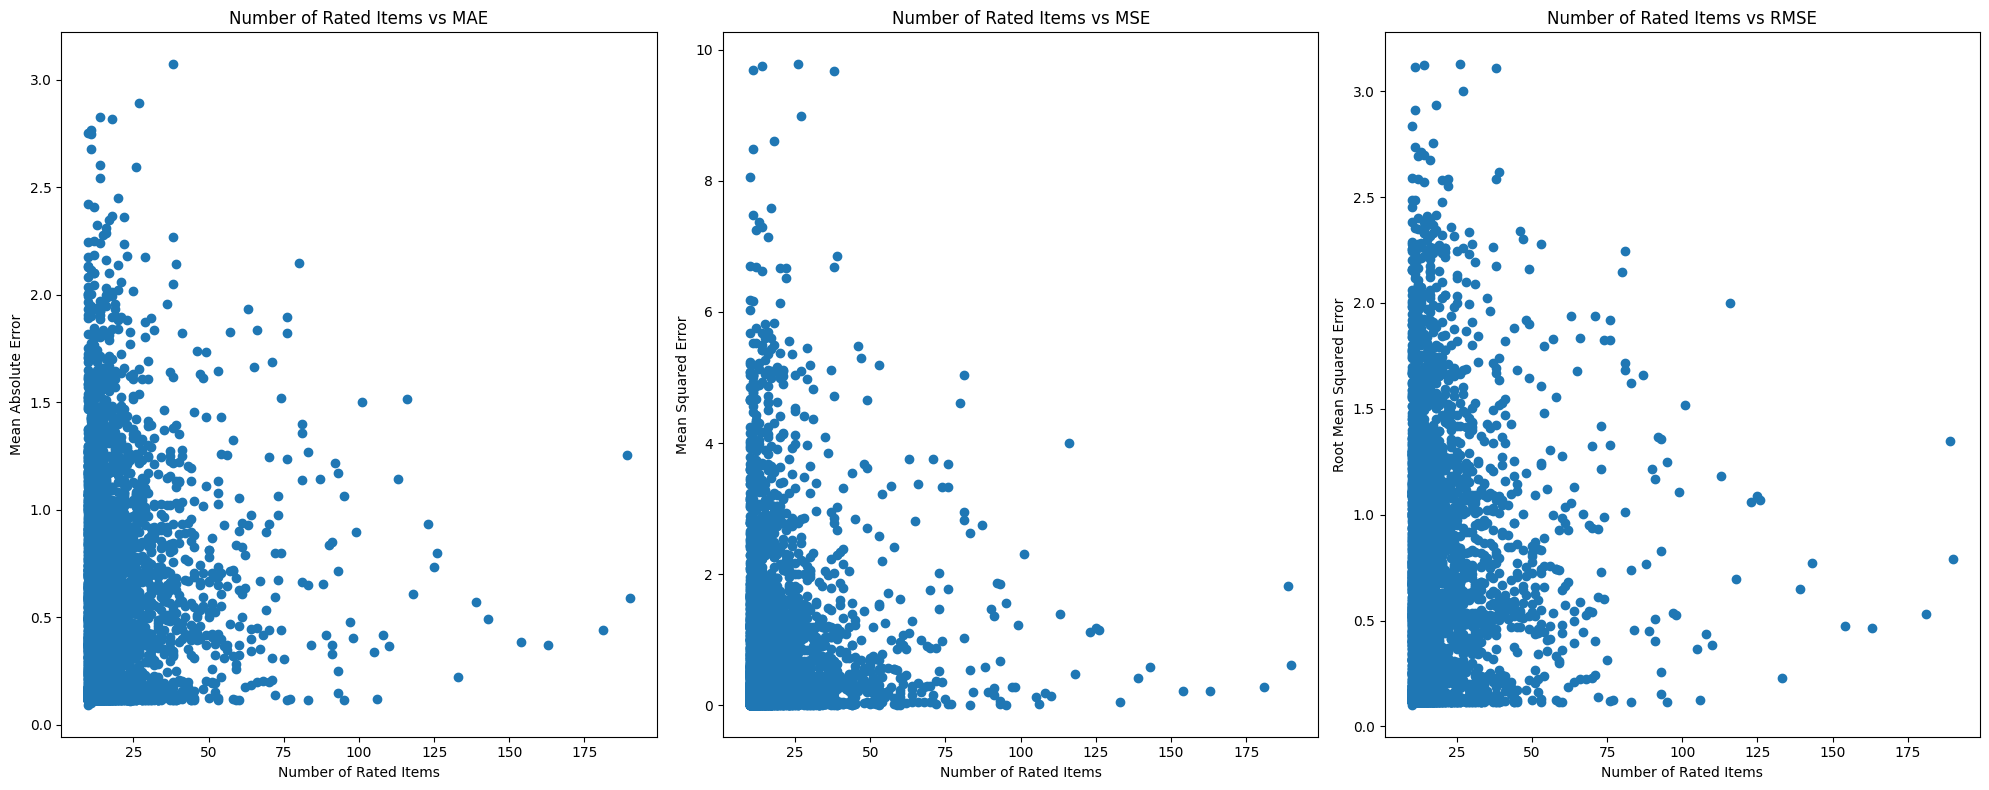

In [63]:
# 4. Visualize the Results: Plot the accuracy metrics (RMSE, MSE, MAE) against the number of rated items for each group. This will help you visualize any patterns or trends in the accuracy of your model based on the number of rated items.
## plot number of rated items vs MAE, MSE, RMSE scatter plot
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.scatter(user_ratings['n_rated_items'], user_ratings['MAE'])
plt.title('Number of Rated Items vs MAE')
plt.xlabel('Number of Rated Items')
plt.ylabel('Mean Absolute Error')

plt.subplot(1, 3, 2)
plt.scatter(user_ratings['n_rated_items'], user_ratings['MSE'])
plt.title('Number of Rated Items vs MSE')
plt.xlabel('Number of Rated Items')
plt.ylabel('Mean Squared Error')

plt.subplot(1, 3, 3)
plt.scatter(user_ratings['n_rated_items'], user_ratings['RMSE'])
plt.title('Number of Rated Items vs RMSE')
plt.xlabel('Number of Rated Items')
plt.ylabel('Root Mean Squared Error')
plt.tight_layout()
plt.show()


In [73]:
# see summary statistics for each group
display(user_ratings.groupby('group').agg({'MAE': ['mean', 'std'], 'MSE': ['mean', 'std'], 'RMSE': ['mean', 'std']}))

# apply anova test
import scipy.stats as stats
f_val, p_val = stats.f_oneway(user_ratings[user_ratings['group'] == 'Low']['RMSE'], user_ratings[user_ratings['group'] == 'Medium']['RMSE'], user_ratings[user_ratings['group'] == 'High']['RMSE'], user_ratings[user_ratings['group'] == 'Very High']['RMSE'])
print(f'F-Value: {f_val}')
print(f'P-Value: {p_val}')

# apply post-hoc test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(user_ratings['RMSE'], user_ratings['group'])
result = mc.tukeyhsd()
print(result)

MAE                 MSE                RMSE          
               mean       std      mean       std      mean       std
group                                                                
Low        0.620661  0.488058  0.854907  1.241115  0.724587  0.574578
Medium     0.582050  0.470661  0.762852  1.160778  0.677338  0.551804
High       0.647980  0.491104  0.904304  1.283824  0.757410  0.575385
Very High  0.637620  0.462966  0.856807  1.223652  0.747393  0.546386

F-Value: 3.010461316096036
P-Value: 0.02900636715158183
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj   lower   upper  reject
-------------------------------------------------------
  High       Low  -0.0328 0.5805 -0.0991  0.0335  False
  High    Medium  -0.0801 0.0317 -0.1553 -0.0049   True
  High Very High    -0.01 0.9837  -0.081   0.061  False
   Low    Medium  -0.0472 0.2744 -0.1148  0.0203  False
   Low Very High   0.0228 0.7871   -0.04  0.0856  False
Medium Very High   0.0701 0.0609 -0.0021  0.1422  False
-------------------------------------------------------
               n_rated_items      RMSE
n_rated_items       1.000000  0.036261
RMSE                0.036261  1.000000


In [75]:
# QUESTION 2: Want to see if accuracy is better for items that have been rated more times. (i.e., for items that have been rated more times, is the accuracy of the model better?)

# Count the number of ratings for each item
item_ratings = train_x.groupby('product')['user'].count().reset_index()
item_ratings.columns = ['product', 'n_ratings']

# Divide items into groups based on the number of ratings
item_ratings['group'] = pd.qcut(item_ratings['n_ratings'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Evaluate the model for each group of items
low_group = item_ratings[item_ratings['group'] == 'Low']
medium_group = item_ratings[item_ratings['group'] == 'Medium']
high_group = item_ratings[item_ratings['group'] == 'High']
very_high_group = item_ratings[item_ratings['group'] == 'Very High']

# get test set items for these groups
low_group_test = test_x[test_x['product'].isin(low_group['product'])]
medium_group_test = test_x[test_x['product'].isin(medium_group['product'])]
high_group_test = test_x[test_x['product'].isin(high_group['product'])]
very_high_group_test = test_x[test_x['product'].isin(very_high_group['product'])]

# get test set ratings for these groups
low_group_ratings = test_y[test_x['product'].isin(low_group['product'])]
medium_group_ratings = test_y[test_x['product'].isin(medium_group['product'])]
high_group_ratings = test_y[test_x['product'].isin(high_group['product'])]
very_high_group_ratings = test_y[test_x['product'].isin(very_high_group['product'])]

# get predictions for these groups
low_group_pred = y_pred[test_x['product'].isin(low_group['product'])]
medium_group_pred = y_pred[test_x['product'].isin(medium_group['product'])]
high_group_pred = y_pred[test_x['product'].isin(high_group['product'])]
very_high_group_pred = y_pred[test_x['product'].isin(very_high_group['product'])]

# set predictions and actual ratings to variables
low_group_ratings_array = (np.array(low_group_ratings)*4 + 1)
low_group_pred_array = np.array(low_group_pred).flatten()

medium_group_ratings_array = (np.array(medium_group_ratings)*4 + 1)
medium_group_pred_array = np.array(medium_group_pred).flatten()

high_group_ratings_array = (np.array(high_group_ratings)*4 + 1)
high_group_pred_array = np.array(high_group_pred).flatten()

very_high_group_ratings_array = (np.array(very_high_group_ratings)*4 + 1)
very_high_group_pred_array = np.array(very_high_group_pred).flatten()

# Rating predictions
low_group_mae = mean_absolute_error(low_group_ratings_array, low_group_pred_array)
low_group_mse = mean_squared_error(low_group_ratings_array, low_group_pred_array)
low_group_rmse = np.sqrt(low_group_mse)

medium_group_mae = mean_absolute_error(medium_group_ratings_array, medium_group_pred_array)
medium_group_mse = mean_squared_error(medium_group_ratings_array, medium_group_pred_array)
medium_group_rmse = np.sqrt(medium_group_mse)

high_group_mae = mean_absolute_error(high_group_ratings_array, high_group_pred_array)
high_group_mse = mean_squared_error(high_group_ratings_array, high_group_pred_array)
high_group_rmse = np.sqrt(high_group_mse)

very_high_group_mae = mean_absolute_error(very_high_group_ratings_array, very_high_group_pred_array)
very_high_group_mse = mean_squared_error(very_high_group_ratings_array, very_high_group_pred_array)
very_high_group_rmse = np.sqrt(very_high_group_mse)

# display results
print("Checking if the number of reviews of an impact the model performance for items.")
results = pd.DataFrame({'MAE': [low_group_mae.round(3), medium_group_mae.round(3), high_group_mae.round(3), very_high_group_mae.round(3)], 'MSE': [low_group_mse.round(3), medium_group_mse.round(3), high_group_mse.round(3), very_high_group_mse.round(3)], 'RMSE': [low_group_rmse.round(3), medium_group_rmse.round(3), high_group_rmse.round(3), very_high_group_rmse.round(3)]})
results.index = ['Low', 'Medium', 'High', 'Very High']
print(f'Number of Items in Low Group: {low_group.shape[0]}')
print(f'Number of Items in Medium Group: {medium_group.shape[0]}')
print(f'Number of Items in High Group: {high_group.shape[0]}')
print(f'Number of Items in Very High Group: {very_high_group.shape[0]}')
results

Checking if the number of reviews of an impact the model performance for items.
Number of Items in Low Group: 974
Number of Items in Medium Group: 672
Number of Items in High Group: 842
Number of Items in Very High Group: 761


,MAE,MSE,RMSE
Low,0.641,0.882,0.939
Medium,0.611,0.807,0.899
High,0.634,0.871,0.933
Very High,0.598,0.811,0.901


In [86]:
# evaluate the performance of model for each item
for item in item_ratings['product']:
    # Filter test set data for the current item
    item_test = test_x[test_x['product'] == item]
    if not item_test.empty:  # Check if there are samples available
        # Get test set ratings for the current item
        items_ratings = test_y[test_x['product'] == item]
        # Get predictions for the current item
        item_pred = y_pred[test_x['product'] == item]
        # Set predictions and actual ratings to variables
        item_ratings_array = (np.array(items_ratings) * 4 + 1)
        item_pred_array = np.array(item_pred).flatten()
        # Rating predictions
        item_mae = mean_absolute_error(item_ratings_array, item_pred_array)
        item_mse = mean_squared_error(item_ratings_array, item_pred_array)
        item_rmse = np.sqrt(item_mse)
        # Assign results to item_ratings
        item_ratings.loc[item, 'MAE'] = item_mae
        item_ratings.loc[item, 'MSE'] = item_mse
        item_ratings.loc[item, 'RMSE'] = item_rmse
    else:
        # No samples available for this item
        print(f"No test set data available for item {item}. Skipping evaluation.")

No test set data available for item 2991. Skipping evaluation.
No test set data available for item 2992. Skipping evaluation.
No test set data available for item 2993. Skipping evaluation.
No test set data available for item 2994. Skipping evaluation.
No test set data available for item 2995. Skipping evaluation.
No test set data available for item 2996. Skipping evaluation.
No test set data available for item 2997. Skipping evaluation.
No test set data available for item 2998. Skipping evaluation.
No test set data available for item 2999. Skipping evaluation.
No test set data available for item 3000. Skipping evaluation.
No test set data available for item 3001. Skipping evaluation.
No test set data available for item 3002. Skipping evaluation.
No test set data available for item 3003. Skipping evaluation.
No test set data available for item 3004. Skipping evaluation.
No test set data available for item 3005. Skipping evaluation.
No test set data available for item 3006. Skipping eval

In [88]:
# how many nas in item_ratings
item_ratings.isna().sum()

#the test set items were randomly selected from the users' rated items list, there's a possibility that certain items may not have been included in the test set due to the random sampling process. As a result, when we attempt to evaluate the model's performance for each item using the test set, some items may not have any corresponding test set data available.

product        0
n_ratings      0
group          0
MAE          258
MSE          258
RMSE         258
dtype: int64

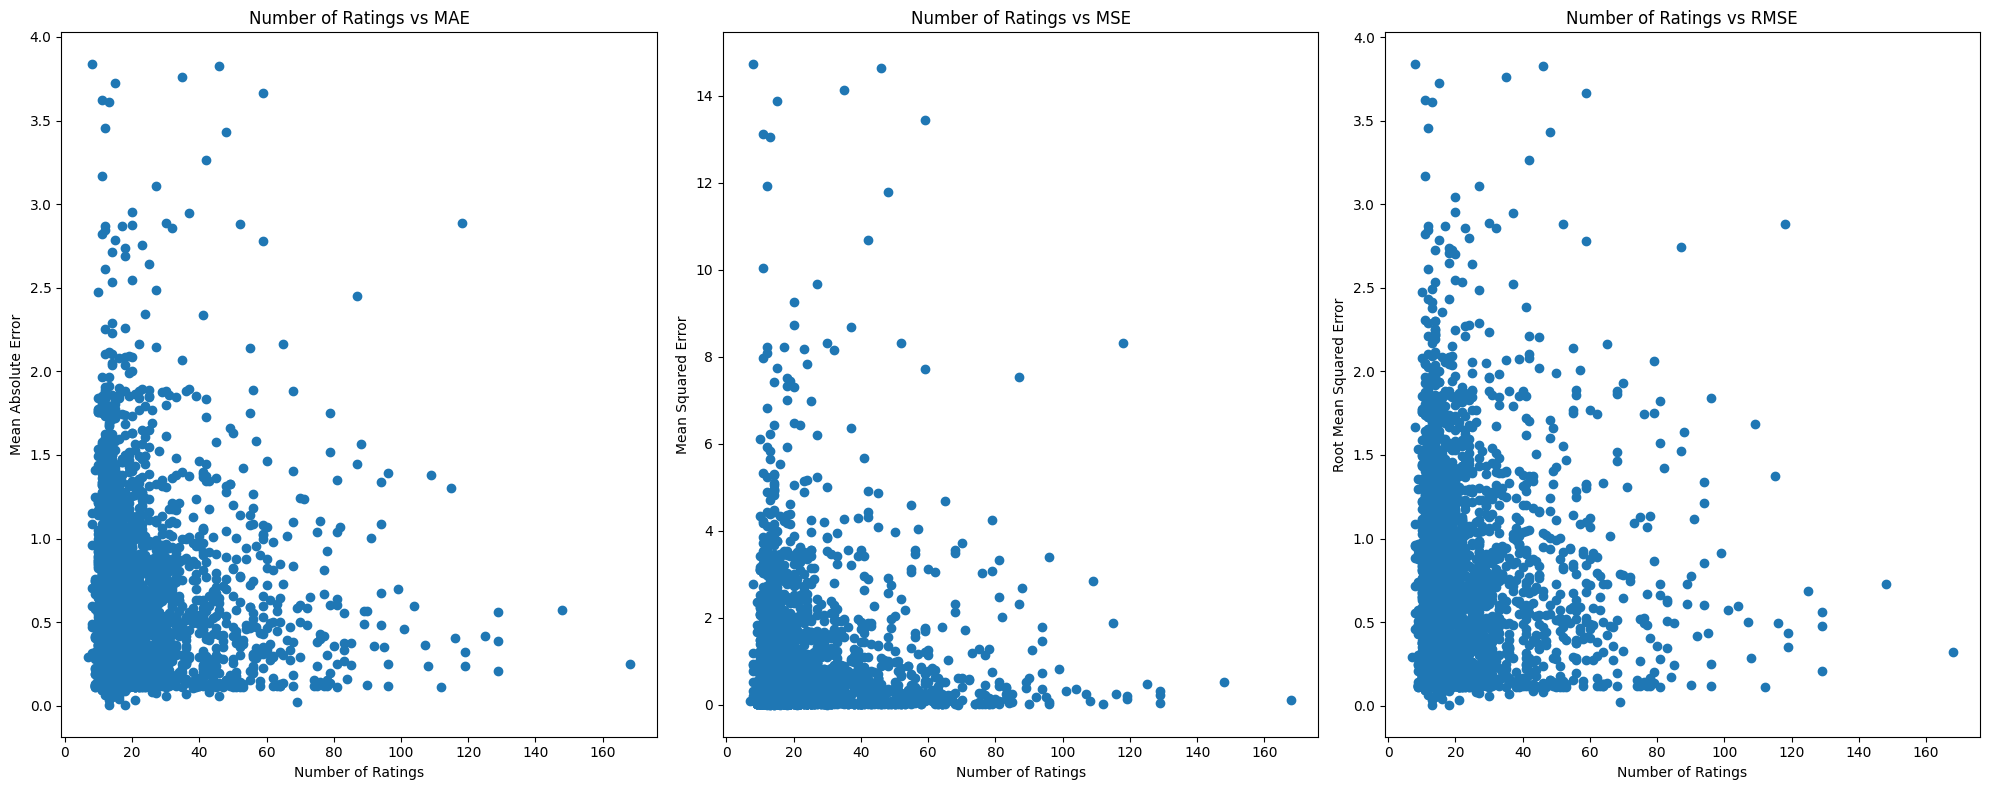

In [89]:
# 4. Visualize the Results: Plot the accuracy metrics (RMSE, MSE, MAE) against the number of reviews for each group. This will help you visualize any patterns or trends in the accuracy of your model based on the number of rated items.¸
## plot number of rated items vs MAE, MSE, RMSE scatter plot
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.scatter(item_ratings['n_ratings'], item_ratings['MAE'])
plt.title('Number of Ratings vs MAE')
plt.xlabel('Number of Ratings')
plt.ylabel('Mean Absolute Error')

plt.subplot(1, 3, 2)
plt.scatter(item_ratings['n_ratings'], item_ratings['MSE'])
plt.title('Number of Ratings vs MSE')
plt.xlabel('Number of Ratings')
plt.ylabel('Mean Squared Error')

plt.subplot(1, 3, 3)
plt.scatter(item_ratings['n_ratings'], item_ratings['RMSE'])
plt.title('Number of Ratings vs RMSE')
plt.xlabel('Number of Ratings')
plt.ylabel('Root Mean Squared Error')

plt.tight_layout()
plt.show()

In [92]:
# see summary statistics for each group
display(item_ratings.groupby('group').agg({'MAE': ['mean', 'std'], 'MSE': ['mean', 'std'], 'RMSE': ['mean', 'std']}))

# apply anova test
item_ratings.dropna(inplace=True)
f_val, p_val = stats.f_oneway(item_ratings[item_ratings['group'] == 'Low']['RMSE'], item_ratings[item_ratings['group'] == 'Medium']['RMSE'], item_ratings[item_ratings['group'] == 'High']['RMSE'], item_ratings[item_ratings['group'] == 'Very High']['RMSE'])
print(f'F-Value: {f_val}')
print(f'P-Value: {p_val}')

# apply post-hoc test
item_ratings['RMSE'] = pd.to_numeric(item_ratings['RMSE'], errors='coerce')  # coerce errors to NaN if conversion fails
mc = MultiComparison(item_ratings['RMSE'], item_ratings['group'])
result = mc.tukeyhsd()
print(result)


MAE                 MSE                RMSE          
               mean       std      mean       std      mean       std
group                                                                
Low        0.663709  0.504423  0.925194  1.426775  0.781172  0.561537
Medium     0.631174  0.475331  0.837417  1.235978  0.741598  0.536584
High       0.650487  0.490031  0.895874  1.312801  0.763874  0.559262
Very High  0.639152  0.542529  0.927502  1.637559  0.755363  0.597843

F-Value: 0.6363154957786595
P-Value: 0.5915801630297236
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj   lower  upper  reject
------------------------------------------------------
  High       Low   0.0173 0.9256 -0.0544  0.089  False
  High    Medium  -0.0223 0.8862  -0.101 0.0565  False
  High Very High  -0.0085 0.9913 -0.0834 0.0664  False
   Low    Medium  -0.0396  0.546 -0.1163 0.0371  False
   Low Very High  -0.0258 0.7983 -0.0985 0.0469  False
Medium Very High   0.0138 0.9708 -0.0659 0.0935  False
------------------------------------------------------


### Top-N Recommendations

#### ***Process***

***TLDR***: adjust  test setit to only contain items that a user liked (above a threshold). Then use my predictions in completed matrix, to get a list of top-N list of items to recommend to the user. If the user has already rated the item, then I will not recommend it. See how many of the recommended items are in the test set.

- By adjusting your test set to only include items that meet or exceed a certain threshold (for example, ratings of 4 or above), we can evaluate our model's performance specifically on predicting items that the user likes or interacts with positively
-  if an item receives a low rating from a user, it is unlikely to be recommended by your model or to be of interest to the user in the future. Therefore, you can focus your evaluation on how well your model predicts high-quality recommendations, which are more likely to lead to user satisfaction and engagement

Here's a step-by-step breakdown:

1. Test Set Adjustment: Modify your test set to only include items that the user liked, typically by setting a threshold for ratings (e.g., only items rated 4 or 5).
2. Predictions: Generate predictions for each user-item pair using your model. For pairs where a user has not rated an item yet, your model should predict a rating.
3. Top Recommendations: Rank the predicted ratings for each user's unrated items and select the top recommendations (e.g., top 100) based on these predicted ratings.
4. Avoiding Already Rated Items: Check if the recommended items are already rated by the user (in your modified test set). If an item is already rated, you should not recommend it.
5. Evaluation: Assess the performance of your recommender system using metrics like Precision and Recall, which evaluate how well your recommendations align with the user's preferences (as captured by the test set).


#### ***Metrics***

**Precision@K:**
- Precision@K measures the proportion of relevant items among the top-K recommended items.
- It answers the question: “Out of the top-K recommendations, how many are actually relevant?”


**Recall@K:**
- It answers the question: “Out of all relevant items, how many were included in the top-K recommendations?”
- Recall@K (also known as Hit Rate@K) measures how well you capture relevant items among all the relevant items.


In [234]:
# getting a dataframe with interactions and ratings
data_mat = data.copy()
data_mat = data_mat.reset_index()
data_mat = data_mat.melt(id_vars=data_mat.columns[0], var_name='product', value_name='rating')
data_mat.columns = ['user', 'product', 'rating']
data_mat['user'] = data_mat['user'].astype('category')
data_mat['product'] = data_mat['product'].astype('category')
data_mat['user'] = data_mat['user'].cat.codes
data_mat['product'] = data_mat['product'].cat.codes
display(data_mat.head(3))

,user,product,rating
0,0,0,NaN
1,1,0,NaN
2,2,0,NaN


In [217]:
# Function to fill NaN ratings with predictions in the user-item dataframe
def fill_nan_ratings_with_predictions(model, data):
    
    # Create a copy of the DataFrame to avoid modifying the original
    completed = data.copy()

    # Find rows with NaN ratings
    nan_rows = completed[completed['rating'].isna()]

    # Predict the ratings for these rows
    predictions = model.predict([nan_rows['user'], nan_rows['product']])
    predictions = predictions * 4 + 1

    # Fill in the predictions
    completed.loc[nan_rows.index, 'rating'] = predictions.flatten()

    return completed

In [ ]:

# Fill NaN ratings with predictions
completed = fill_nan_ratings_with_predictions(model=best_model, data=data_mat)

In [24]:
# see original data with user item interactions
print("User Item Interactions with Ratings")
display(data_mat.head(3))

# see data with predictions
print("\nUser Item Interactions with Predicted Ratings")
display(completed.head(3))

User Item Interactions with Ratings


,user,product,rating
0,0,0,NaN
1,1,0,NaN
2,2,0,NaN



User Item Interactions with Predicted Ratings


,user,product,rating
0,0,0,4.249067
1,1,0,3.657794
2,2,0,4.018017


In [25]:
# details on completed dataframe
print('Number of Rows: ', completed.shape[0])
print('Number of Columns: ', completed.shape[1])
print('Number of Unique Users: ', len(completed['user'].unique()))
print('Number of Unique Products: ', len(completed['product'].unique()))

Number of Rows:  11917332
Number of Columns:  3
Number of Unique Users:  3668
Number of Unique Products:  3249


In [26]:
print("Test Data: X")
display(test_x.head(3))
print('Shape of Test Data: ', test_x.shape)

# Define the threshold for positive interaction
test_y_top_n = test_y.copy()
test_y_top_n = pd.DataFrame(test_y_top_n)
test_y_top_n = test_y_top_n* 4 + 1

# Now, test_y will have a 'label' column with 0 for negative interactions and 1 for positive interactions
print("\nTest Data: Y")
display(test_y_top_n.head(3))
print('Shape of Test Data: ', test_y_top_n.shape)

# predicted data
print("\nPredicted Data")
predicted_rats = pd.Series(predicted_ratings_array)
predicted_rats.index = test_y.index
display(predicted_rats.head(3))

Test Data: X


,user,product
174,174,0
4473,805,1
4869,1201,1


Shape of Test Data:  (11004, 2)

Test Data: Y


,rating
174,3.0
4473,5.0
4869,5.0


Shape of Test Data:  (11004, 1)

Predicted Data


174     4.356881
4473    4.732635
4869    4.869822
dtype: float32

#### Execute for One User

1. Test Set Adjustment: Modify your test set to only include items that the user liked, typically by setting a threshold for ratings (e.g., only items rated 4 or 5).
2. Predictions: Generate predictions for each user-item pair using your model. For pairs where a user has not rated an item yet, your model should predict a rating.
3. Top Recommendations: Rank the predicted ratings for each user's unrated items and select the top recommendations (e.g., top 100) based on these predicted ratings.
4. Avoiding Already Rated Items: Check if the recommended items are already rated by the user (in your modified test set). If an item is already rated, you should not recommend it.
5. Evaluation: Assess the performance of your recommender system using metrics like Precision and Recall, which evaluate how well your recommendations align with the user's preferences (as captured by the test set).


In [105]:
# set N - number of recommendations
N = 1000

# Get interactions for User 1 (including ratings)
user_1 = completed[completed['user'] == 0]
print("Number of Interactions for User 1: ", user_1.shape[0])

# Identify liked items for User 1 (above a threshold, e.g., rating > 3)
liked_items = user_1[user_1['rating'] > 3.5]
print("Number of Liked Items for User 1: ", liked_items.shape[0])

# get test set for user 1, including actual ratings and predicted ratings
user_1_test = test_x[test_x['user'] == 0]
user_1_test['actual_rating'] = test_y_top_n
user_1_test['predicted_rating'] = predicted_rats[user_1_test.index]
print("Number of Test Interactions for User 1: ", user_1_test.shape[0])


# threshold for positive interaction
threshold = 3.5
print("Number of Test Interactions that the User Liked: ", user_1_test[user_1_test['actual_rating'] > threshold].shape[0])

# adjust test set to include a label column using the threshold
user_1_test['label'] = user_1_test['actual_rating'].apply(lambda x: 1 if x > threshold else 0)
user_1_test

# get predictions for user 
completed_user_1 = completed[completed['user'] == 0]


# add label for used interactions (add 1 to all interactions that exist in train_x)
train_x_user_1 = train_x[train_x['user'] == 0]

# for each user interaction, check if it exists in train_x
completed_user_1['used_ind'] = 0
for i in range(completed_user_1.shape[0]):
    if completed_user_1.iloc[i, 1] in list(train_x_user_1['product']):
        completed_user_1.iloc[i, 3] = 1


# count how many interactions are in train_x
print("Number of Interactions in Train Set for User 1: ", train_x_user_1.shape[0])

# count how many 1 in completed_user_1
print("Number of Interactions in Completed User 1: ", completed_user_1[completed_user_1['used_ind'] == 1].shape[0])

# add label liked for completed_user_1
completed_user_1['liked'] = completed_user_1['rating'].apply(lambda x: 1 if x > threshold else 0)


# get top N recommendations for user 1 - exclude items where used_ind = 1
user_1_top_n = completed_user_1[completed_user_1['used_ind'] == 0]
user_1_top_n = user_1_top_n.sort_values(by='rating', ascending=False)
user_1_top_n = user_1_top_n.head(N)


# add a label column to user_1_top_n: test_ind
user_1_top_n['test_ind'] = 0
for i in range(user_1_top_n.shape[0]):
    if user_1_top_n.iloc[i, 1] in list(user_1_test[user_1_test['label'] == 1]['product']):
        user_1_top_n.iloc[i, 5] = 1


# count how many 1 in user_1_top_n
print("Number of Items in Top N for User 1 that Were Used and Liked: ", user_1_top_n[user_1_top_n['test_ind'] == 1].shape[0])

# see top N recommendations for user 1
print("\n\nTop N Recommendations for User 1")
display(user_1_top_n)


# Calculate precision@K (top N recommendations)
precision_at_N = user_1_top_n['test_ind'].sum() / N

# Calculate recall@K
recall_at_N = user_1_top_n['test_ind'].sum() / liked_items.shape[0]

# calculate F1 score
f1_at_N = 2 * (precision_at_N * recall_at_N) / (precision_at_N + recall_at_N)

print(f"Precision@{N}: {precision_at_N:.4f}")
print(f"Recall@{N}: {recall_at_N:.4f}")
print(f"F1@{N}: {f1_at_N:.4f}")

# save results to csv
results = pd.DataFrame({'Precision@N': [precision_at_N], 'Recall@N': [recall_at_N], 'F1@N': [f1_at_N]})
results

Number of Interactions for User 1:  3249
Number of Liked Items for User 1:  3234
Number of Test Interactions for User 1:  3
Number of Test Interactions that the User Liked:  2
Number of Interactions in Train Set for User 1:  37
Number of Interactions in Completed User 1:  37
Number of Items in Top N for User 1 that Were Used and Liked:  2


Top N Recommendations for User 1


,user,product,rating,used_ind,liked,test_ind
9709196,0,2647,5.000000,0,1,0
8282344,0,2258,5.000000,0,1,0
983024,0,268,4.870960,0,1,0
8421728,0,2296,4.870951,0,1,0
4698708,0,1281,4.870340,0,1,0
...,...,...,...,...,...,...
3550624,0,968,4.858325,0,1,0
806960,0,220,4.858302,0,1,0
4419940,0,1205,4.858300,0,1,0
5560688,0,1516,4.858295,0,1,0


Precision@1000: 0.0020
Recall@1000: 0.0006
F1@1000: 0.0009


,Precision@N,Recall@N,F1@N
0,0.002,0.000618,0.000945


In [219]:
def evaluate_topN_user(user, threshold, N, data):
    # Get interactions for the specified user (including ratings)
    user_interactions = data[data['user'] == user]
    print("\nNumber of Interactions for User {}: {}".format(user, user_interactions.shape[0]))

    # Identify liked items for the specified user (above the specified threshold)
    liked_items = user_interactions[user_interactions['rating'] >= threshold]
    print("Number of Liked Items for User {}: {}".format(user, liked_items.shape[0]))

    # Get the test set for the specified user, including actual ratings and predicted ratings
    user_test_set = test_x[test_x['user'] == user]
    user_test_set['actual_rating'] = test_y_top_n
    user_test_set['predicted_rating'] = predicted_rats[user_test_set.index]
    print("Number of Test Interactions for User {}: {}".format(user, user_test_set.shape[0]))

    # Adjust the test set to include a label column using the specified threshold
    user_test_set['label'] = user_test_set['actual_rating'].apply(lambda x: 1 if x > threshold else 0)

    # Count the number of interactions in the train set for the specified user
    train_x_user = train_x[train_x['user'] == user]
    print("Number of Interactions in Train Set for User {}: {}\n\n".format(user, train_x_user.shape[0]))

    # Add a label for used interactions (add 1 to all interactions that exist in train_x)
    user_interactions['used_ind'] = 0
    for i in range(user_interactions.shape[0]):
        if user_interactions.iloc[i, 1] in list(train_x_user['product']):
            user_interactions.iloc[i, 3] = 1

    # Add a label for liked items
    user_interactions['liked'] = user_interactions['rating'].apply(lambda x: 1 if x > threshold else 0)

    # Get the top N recommendations for the specified user (excluding items where used_ind = 1)
    user_top_n = user_interactions[user_interactions['used_ind'] == 0]
    user_top_n = user_top_n.sort_values(by='rating', ascending=False)
    user_top_n = user_top_n.head(N)

    # Add a label column to user_top_n: test_ind
    user_top_n['test_ind'] = 0
    for i in range(user_top_n.shape[0]):
        if user_top_n.iloc[i, 1] in list(user_test_set[user_test_set['label'] == 1]['product']):
            user_top_n.iloc[i, 5] = 1

    # Calculate Precision@N, Recall@N, and F1@N
    precision_at_N = user_top_n['test_ind'].sum() / N
    recall_at_N = user_top_n['test_ind'].sum() / liked_items.shape[0]
    if precision_at_N + recall_at_N == 0:
        f1_at_N = 0
    else: f1_at_N = 2 * (precision_at_N * recall_at_N) / (precision_at_N + recall_at_N)

    # Display the results
    print(f"Results for User {user} with Threshold {threshold} and Top {N} Recommendations!")
    print(f"Precision@{N}: {precision_at_N:.4f}")
    print(f"Recall@{N}: {recall_at_N:.4f}")
    print(f"F1@{N}: {f1_at_N:.4f}")

    # Save the results to a dataframe and return it
    results = pd.DataFrame({'Precision@N': [precision_at_N], 'Recall@N': [recall_at_N], 'F1@N': [f1_at_N]})
    return results


In [ ]:
def evaluate_topN_user(user, threshold, N, data):
    # Get interactions for the specified user (including ratings)
    user_interactions = data[data['user'] == user]
    print("\nNumber of Interactions for User {}: {}".format(user, user_interactions.shape[0]))

    # Identify liked items for the specified user (above the specified threshold)
    liked_items = user_interactions[user_interactions['rating'] >= threshold]
    print("Number of Liked Items for User {}: {}".format(user, liked_items.shape[0]))

    # Get the test set for the specified user, including actual ratings and predicted ratings
    user_test_set = test_x[test_x['user'] == user]
    user_test_set['actual_rating'] = test_y_top_n
    user_test_set['predicted_rating'] = predicted_rats[user_test_set.index]
    print("Number of Test Interactions for User {}: {}".format(user, user_test_set.shape[0]))

    # Adjust the test set to include a label column using the specified threshold
    user_test_set['label'] = user_test_set['actual_rating'].apply(lambda x: 1 if x > threshold else 0)

    # Count the number of interactions in the train set for the specified user
    train_x_user = train_x[train_x['user'] == user]
    print("Number of Interactions in Train Set for User {}: {}\n\n".format(user, train_x_user.shape[0]))

    # Add a label for used interactions (add 1 to all interactions that exist in train_x)
    user_interactions['used_ind'] = 0
    for i in range(user_interactions.shape[0]):
        if user_interactions.iloc[i, 1] in list(train_x_user['product']):
            user_interactions.iloc[i, 3] = 1

    # Add a label for liked items
    user_interactions['liked'] = user_interactions['rating'].apply(lambda x: 1 if x > threshold else 0)

    # Get the top N recommendations for the specified user (excluding items where used_ind = 1)
    user_top_n = user_interactions[user_interactions['used_ind'] == 0]
    user_top_n = user_top_n.sort_values(by='rating', ascending=False)
    user_top_n = user_top_n.head(N)

    # Add a label column to user_top_n: test_ind
    user_top_n['test_ind'] = 0
    for i in range(user_top_n.shape[0]):
        if user_top_n.iloc[i, 1] in list(user_test_set['product']):
            user_top_n.iloc[i, 5] = 1

    # Calculate Precision@N, Recall@N, and F1@N
    precision_at_N = user_top_n['test_ind'].sum() / N
    recall_at_N = user_top_n['test_ind'].sum() / liked_items.shape[0]
    if precision_at_N + recall_at_N == 0:
        f1_at_N = 0
    else: f1_at_N = 2 * (precision_at_N * recall_at_N) / (precision_at_N + recall_at_N)

    # Display the results
    print(f"Results for User {user} with Threshold {threshold} and Top {N} Recommendations!")
    print(f"Precision@{N}: {precision_at_N:.4f}")
    print(f"Recall@{N}: {recall_at_N:.4f}")
    print(f"F1@{N}: {f1_at_N:.4f}")

    # Save the results to a dataframe and return it
    results = pd.DataFrame({'Precision@N': [precision_at_N], 'Recall@N': [recall_at_N], 'F1@N': [f1_at_N]})
    return results


In [195]:
# use function
results = evaluate_topN_user(user=0, threshold=3, N=100, data=completed)


Number of Interactions for User 0: 3249
Number of Liked Items for User 0: 3249
Number of Test Interactions for User 0: 3
Number of Interactions in Train Set for User 0: 37


Results for User 0 with Threshold 3 and Top 100 Recommendations!
Precision@100: 0.0000
Recall@100: 0.0000
F1@100: 0.0000


#### Get for All Users

It defines a function `evaluate_topN_user` that calculates the metrics for a specified `user`, `threshold`, and `N`. The function returns a dataframe with the results.

It then loops through each user in the '`completed`' dataframe and calls the `evaluate_topN_user` function to calculate the metrics for each user. The results for each user are appended to the results dataframe.

Finally, it **calculates the average of the metrics across all users and displays the aggregate metrics.**


In [199]:
# loop through users to get results for each user and save to a dataframe
results = pd.DataFrame()
for user in range(len(completed['user'].unique())):
    user_results = evaluate_topN_user(user=user, threshold=3, N=10000, data=completed)
    results = pd.concat([results, user_results])

results


Number of Interactions for User 0: 3249
Number of Liked Items for User 0: 3249
Number of Test Interactions for User 0: 3
Number of Interactions in Train Set for User 0: 37


Results for User 0 with Threshold 3 and Top 10000 Recommendations!
Precision@10000: 0.0002
Recall@10000: 0.0006
F1@10000: 0.0003

Number of Interactions for User 1: 3249
Number of Liked Items for User 1: 3247
Number of Test Interactions for User 1: 3
Number of Interactions in Train Set for User 1: 43


Results for User 1 with Threshold 3 and Top 10000 Recommendations!
Precision@10000: 0.0003
Recall@10000: 0.0009
F1@10000: 0.0005

Number of Interactions for User 2: 3249
Number of Liked Items for User 2: 3249
Number of Test Interactions for User 2: 3
Number of Interactions in Train Set for User 2: 15


Results for User 2 with Threshold 3 and Top 10000 Recommendations!
Precision@10000: 0.0003
Recall@10000: 0.0009
F1@10000: 0.0005

Number of Interactions for User 3: 3249
Number of Liked Items for User 3: 3247
Number o

,Precision@N,Recall@N,F1@N
0,0.0002,0.000616,0.000302
0,0.0003,0.000924,0.000453
0,0.0003,0.000923,0.000453
0,0.0003,0.000924,0.000453
0,0.0003,0.000923,0.000453
...,...,...,...
0,0.0003,0.000923,0.000453
0,0.0002,0.000616,0.000302
0,0.0003,0.000923,0.000453
0,0.0003,0.000923,0.000453


In [200]:
# Get the average results for all users
average_results = results.mean()
average_results

Precision@N    0.000254
Recall@N       0.000783
F1@N           0.000384
dtype: float64

In [201]:
results = pd.DataFrame({'Precision@N': [precision_at_N], 'Recall@N': [recall_at_N], 'F1@N': [f1_at_N]})
results.to_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/Results/NCF_results_1_topN.csv', index=False)

***
## Model 2: Ratings + Reviews

In [8]:
# load data
# amz_data = pd.read_csv(r'C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\Data\set3_data_modelling.csv')
amz_data = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/set3_data_modelling.csv')
text_embeddings = pd.read_csv(r'/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/NCF Data/text_embeddings.csv')
display(amz_data.head())

# print details
print('Number of Rows: ', amz_data.shape[0])
print('Number of Columns: ', amz_data.shape[1])
print('Number of Unique Users: ', len(amz_data['reviewerID'].unique()))
print('Number of Unique Products: ', len(amz_data['asin'].unique()))


# Creating User Item Matrix =====================================================
# create user-item matrix
data = amz_data.pivot_table(index='reviewerID', columns='asin', values='overall')
print("\n\nUser-Item Matrix")
display(data.head())

,reviewerID,reviewTime,asin,overall,reviewText,stemmed_words_revText,lemmatised_reviewText,filtered_tokens_revText,sentiments_afinn,sentiments_bing,sentiments_vader
0,AQ8OO59DJFJNZ,2018-01-05,0767834739,5.0,wonderful movie,wonder movi,wonderful movie,wonderful movie,4,1,0.5719
1,A244CRJ2QSVLZ4,2008-01-29,0767834739,5.0,resident evil is a great science fictionhorror...,resid evil great scienc fictionhorror hybrid p...,resident evil great science fictionhorror hybr...,resident evil great science fictionhorror hybr...,-12,-5,-0.9455
2,A1VCLTAGM5RLND,2005-07-23,0767834739,5.0,i this movie has people living and working und...,movi peopl live work underground place call hi...,movie people living working underground place ...,movie people living working underground place ...,-1,0,-0.1806
3,A119Q9NFGVOEJZ,2016-02-13,0767834739,5.0,every single video game based movie from the s...,everi singl video game base movi super mario b...,every single video game based movie super mari...,every single video game based movie super mari...,18,6,0.9846
4,A1RP6YCOS5VJ5I,2006-09-26,0767834739,5.0,i think that i like this movie more than the o...,think like movi origin origin still great real...,think like movie original original still great...,think like movie original original still great...,29,10,0.9951


Number of Rows:  83139
Number of Columns:  11
Number of Unique Users:  3668
Number of Unique Products:  3249


User-Item Matrix


asin,0767834739,7799146915,B00000DMAT,B00000DMAX,B00000DMB3,B00000F1GM,B00000I1BJ,B00000I1BY,B00000ID61,B00000INR2,...,B01H353FLA,B01H353HUY,B01H3VFR6U,B01H5GB8ZW,B01H6OXQFS,B01H9SH2LU,B01HGBAFNC,B01HHVVLGQ,B01HHVWWMI,B01HIZF7XE
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100RH4M1W1DF0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
A1027EV8A9PV1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103KKI1Y4TFNQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1047P9FLHTDZJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Word Embeddings

- https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/tensorFlow2/variations/universal-sentence-encoder/versions/2?tfhub-redirect=true

In [9]:
# import tensorflow as tf
# import tensorflow_hub as hub

# # load the model for sentence embeddings
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
# sent_model = hub.load(module_url)
# print(f"Module {module_url} loaded")

# # Embedding review text
# print("Applying the Universal Sentence Encoder on the review text...")
# review_text = amz_data['reviewText']  # Replace with your actual column name
# text_embeddings = sent_model(review_text)
# print("Review text embeddings generated!")
# print(f"Shape of Text Embeddings: {text_embeddings.shape}")

# # attach embeddings to dataframe
# text_embeddings = text_embeddings.numpy()
# text_embeddings = pd.DataFrame(text_embeddings)
# text_embeddings['revText'] = amz_data['reviewText']
# text_embeddings['asin'] = amz_data['asin']
# text_embeddings['reviewerID'] = amz_data['reviewerID']
display(text_embeddings.head(4))

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,revText,asin,reviewerID
0,-0.011411,0.012732,0.012249,-0.029770,0.032968,0.066360,-0.015612,-0.003035,-0.016978,0.029414,...,0.062207,-0.035347,0.011524,-0.036790,-0.030792,0.104588,0.000913,wonderful movie,0767834739,AQ8OO59DJFJNZ
1,0.016304,0.052245,-0.044929,-0.003093,0.030458,-0.015125,0.063519,-0.023906,0.013280,-0.034587,...,-0.061882,-0.062525,-0.012602,-0.040133,-0.000692,0.068579,0.023263,resident evil is a great science fictionhorror...,0767834739,A244CRJ2QSVLZ4
2,0.003858,0.014974,0.003381,-0.023209,0.053806,-0.059621,0.050380,-0.010782,-0.069886,-0.072230,...,0.004721,-0.043190,-0.042796,0.008850,-0.054297,0.075987,0.062721,i this movie has people living and working und...,0767834739,A1VCLTAGM5RLND
3,-0.003534,-0.056638,-0.049522,-0.006381,0.007624,0.006230,0.037928,-0.059353,-0.064795,-0.009551,...,0.058787,-0.064053,-0.006464,0.064920,-0.062360,0.065526,-0.062345,every single video game based movie from the s...,0767834739,A119Q9NFGVOEJZ


#### Training and Test Sets

In [10]:
# DATA PREP ====================================

# create a copy of the original matrix to store hidden ratings
x_hidden = data.copy()
indices_tracker = []

# number of products to hide for each user
N = 3

# identifies rated items and randomly selects N products to hide ratings for each user
np.random.seed(2207)  # You can use any integer value as the seed
for user_id in range(x_hidden.shape[0]):
    rated_products = np.where(x_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_products, N, replace=False)
    indices_tracker.append(hidden_indices)
    x_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = x_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'product', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = x_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='product', value_name='rating')

# change rows with hidden ratings to NaN
data_hidden.iloc[indices_hidden, 2] = np.nan

# rename columns
data_hidden.columns = ['user', 'product', 'rating']

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# add text embeddings to the data (match user and product to the embeddings)
data_hidden = pd.merge(data_hidden, text_embeddings, how='outer', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
data_hidden.drop(['revText', 'asin','reviewerID'], axis=1, inplace=True)

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# Convert user and item to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['product'] = data_hidden['product'].astype('category')

# see what the data looks like
display(data_hidden.head(4))
print("Data is in format: user, product, rating, text embeddings.\nIt is ready to be partitioned into training and testing sets.")

,user,product,rating,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,A100RH4M1W1DF0,B001NJJOCW,5.0,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
1,A100RH4M1W1DF0,B003SIOXTA,5.0,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
2,A100RH4M1W1DF0,B003ZXCAAC,5.0,-0.009528,-0.077318,-0.078732,-0.022566,0.020784,0.040238,0.036082,...,-0.001551,-0.000948,-0.083168,0.060334,0.077315,-0.022964,0.076978,-0.033895,0.033755,0.004203
3,A100RH4M1W1DF0,B00AA8WPGY,5.0,-0.041756,-0.010512,0.014876,-0.018273,-0.043437,-0.015833,-0.048072,...,0.008394,0.021828,0.048689,-0.000628,-0.007572,0.048054,0.008952,0.060675,0.000830,0.021475


Data is in format: user, product, rating, text embeddings.
It is ready to be partitioned into training and testing sets.


In [6]:
# # save data 
# data_hidden.to_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/NCF Data/data_hidden.csv', index=False)    
# text_embeddings.to_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/NCF Data/text_embeddings.csv', index=False)

# load data
# data_hidden = pd.read_csv(r'/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/NCF Data/data_hidden.csv')
# text_embeddings = pd.read_csv(r'/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/NCF Data/text_embeddings.csv')

# data_hidden['user'] = data_hidden['user'].astype('category')
# data_hidden['product'] = data_hidden['product'].astype('category')



In [11]:
# TEST AND TRAIN DATA ====================================

# Prepare the data - trining
train_x = data_hidden[['user', 'product']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

# add text embeddings to the training data (merge on index)
train_x = pd.merge(train_x, data_hidden, how='outer', left_index=True, right_index=True)
train_x.drop(['user_y', 'product_y', 'rating'], axis=1, inplace=True)
train_x.rename(columns={'user_x': 'user', 'product_x': 'product'}, inplace=True)

# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='product', value_name='rating')
copy.columns = ['user', 'product', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]


# add text embeddings to the testing data (merge on user and product)
test_x = pd.merge(test_x, text_embeddings, how='left', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
test_x.drop(['revText', 'asin','reviewerID'], axis=1, inplace=True)
test_x['user'] = test_x['user'].astype('category')
test_x['product'] = test_x['product'].astype('category')

# use cat codes to convert to numerical (for user and product)
test_x['user'] = test_x['user'].cat.codes
test_x['product'] = test_x['product'].cat.codes
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

# show the data
print("Training Data")
display(train_x.head(3))

print("\nTesting Data")
display(test_x.head(3))

Training Data


,user,product,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
0,0,993,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,0.019613,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
1,0,1189,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,0.019613,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
2,0,1203,-0.009528,-0.077318,-0.078732,-0.022566,0.020784,0.040238,0.036082,0.019240,...,-0.001551,-0.000948,-0.083168,0.060334,0.077315,-0.022964,0.076978,-0.033895,0.033755,0.004203



Testing Data


,user,product,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
0,174,0,0.039119,-0.059384,-0.027734,-0.032066,0.045529,0.051033,0.016597,-0.020671,...,-0.011423,-0.062120,0.006031,-0.036203,-0.060012,0.018534,0.053185,0.039681,0.062120,0.057558
1,805,1,0.033977,-0.053225,-0.040635,-0.042631,0.037649,-0.014275,0.010381,-0.050364,...,-0.019601,-0.061564,0.051966,0.011331,-0.046066,0.058120,0.050817,0.058296,0.061771,0.019092
2,1201,1,0.045144,-0.061331,-0.039053,0.068657,0.053297,-0.012607,-0.045700,0.023360,...,-0.004607,-0.074282,-0.033336,-0.017320,0.036439,0.029585,-0.000270,0.003543,0.074316,0.049292


#### NCF Model with Reviews


**Inputs:**
You have three input layers:
- `user_input`: Represents the user ID (integer).
- `product_input`: Represents the product ID (integer).
- `text_input`: Represents the text embeddings of user reviews (float32).

**Embeddings:**
You create embeddings for users and products using the Embedding layer. These embeddings are essential for capturing latent features.
- `user_embedding`: Embedding for user IDs.
- `product_embedding`: Embedding for product IDs.

**Flattening and Concatenation**:
You flatten the user and product embeddings to create vectors (`user_vecs` and `product_vecs`).
Then, you concatenate these vectors with the text embeddings (`text_input`) to form the combined input vector (`input_vecs`).

**Hidden Layers:**
You use a loop to create hidden layers:
For the first layer (i == 0), you apply a Dense layer with ReLU activation and dropout.
For subsequent layers, you reduce the number of nodes by half and apply the same architecture.

**Output Layer**:
The final output layer (*y*) predicts the user-item interaction (*rating*).

**Model Compilation**:
You compile the model using the specified optimizer (Adam, SGD, or RMSprop) and the mean squared error (MSE) loss.

**Training:**
The model is trained using user and product data (`train_x['user']` and `train_x['product']`) along with the target variable (`train_y`).
You split the data into training and validation sets (10% validation split).

**Return:**
The function returns the trained model and training history.

In [12]:
# Function to train a neural network model for collaborative filtering with text embeddings
def train_model_2(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2_reg, train_x, train_y, text_embedding_dim, seed=2207, train_plot=True, callback=True):
    np.random.seed(seed)

    # Inputs
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')
    text_input = Input(shape=(text_embedding_dim,), dtype='float32', name='text_input') 

    # Embeddings
    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    product_embedding = Embedding(input_dim=len(data_hidden['product'].cat.categories), output_dim=50, name='product_embedding')(product_input)

    # Flatten
    user_vecs = Flatten()(user_embedding)
    product_vecs = Flatten()(product_embedding)

    # Concatenate user, product, and text embeddings
    input_vecs = Concatenate()([user_vecs, product_vecs, text_input])

    # Add dense layers
    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu', kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu', kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout)(x)
    y = Dense(1)(x)

    # Compile and train the model
    model = Model(inputs=[user_input, product_input, text_input], outputs=y)

    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    # Define early stopping
    if callback:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Train the model
    if callback:
        history = model.fit([train_x['user'], train_x['product'], train_x.iloc[:, 2:]], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])
    else:
        history = model.fit([train_x['user'], train_x['product'], train_x.iloc[:, 2:]], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    # history = model.fit([train_x['user'], train_x['product'], train_x.iloc[:, 2:]], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

    # Plot training & validation loss values
    if train_plot:
        # Plot training & validation loss values
        plt.figure(figsize=(15, 8))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        # plt.title(f'Model loss for Architecture: {optimizer} optimizer, {n_layers} layers, {n_nodes} nodes, {epochs} epochs, {learning_rate} learning rate, {batch_size} batch size')
        plt.ylabel('Loss', fontsize=40)
        plt.xlabel('Epoch', fontsize = 40)
        plt.xticks(fontsize=36)
        plt.yticks(fontsize=36)
        plt.tight_layout()
        plt.savefig("/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Final Writing/Figures/ncf_training_2.pdf")
        plt.show()

    
    return model, history


In [13]:
# Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
# print("Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
# model, history = train_model_2(n_layers=2, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01,  seed=10, train_plot=False, callback = True)

model, history = train_model_2(n_layers=2, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=128, dropout=0.5, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=2207, train_plot=False, callback=True, text_embedding_dim = text_embeddings.shape[1]-3)

# model, history = train_model_1(n_layers=2, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=128, dropout=0.5, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=10, train_plot=True, callback=True)

# # Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
# print("Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
# model2, history2 = train_model_2(n_layers=3, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01,seed=10, train_plot=False, callback = True)

# # Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
# print("Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
# model3, history3 = train_model_2(n_layers=4, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01,seed=10, train_plot=False, callback = True)

# # Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
# print("Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
# model4, history4 = train_model_2(n_layers=5, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01,seed=10, train_plot=False, callback = True)

Epoch 1/50
508/508 [==============================] - 6s 10ms/step - loss: 0.5213 - val_loss: 0.0571
Epoch 2/50
508/508 [==============================] - 5s 10ms/step - loss: 0.0526 - val_loss: 0.0539
Epoch 3/50
508/508 [==============================] - 5s 10ms/step - loss: 0.0482 - val_loss: 0.0545
Epoch 4/50
508/508 [==============================] - 4s 9ms/step - loss: 0.0456 - val_loss: 0.0496
Epoch 5/50
508/508 [==============================] - 5s 9ms/step - loss: 0.0435 - val_loss: 0.0534
Epoch 6/50
508/508 [==============================] - 4s 9ms/step - loss: 0.0423 - val_loss: 0.0505
Epoch 7/50
508/508 [==============================] - 4s 9ms/step - loss: 0.0413 - val_loss: 0.0496
Epoch 8/50
508/508 [==============================] - 4s 9ms/step - loss: 0.0406 - val_loss: 0.0493
Epoch 9/50
508/508 [==============================] - 4s 9ms/step - loss: 0.0402 - val_loss: 0.0474
Epoch 10/50
508/508 [==============================] - 4s 9ms/step - loss: 0.0395 - val_loss: 0.0

#### Training Results

In [8]:
# Which model had lowest validation loss?
print("Model 1 Validation Loss: ", min(history.history['val_loss']))
# print("Model 2 Validation Loss: ", min(history2.history['val_loss']))
# print("Model 3 Validation Loss: ", min(history3.history['val_loss']))
# print("Model 4 Validation Loss: ", min(history4.history['val_loss']))

Model 1 Validation Loss:  0.04445233568549156


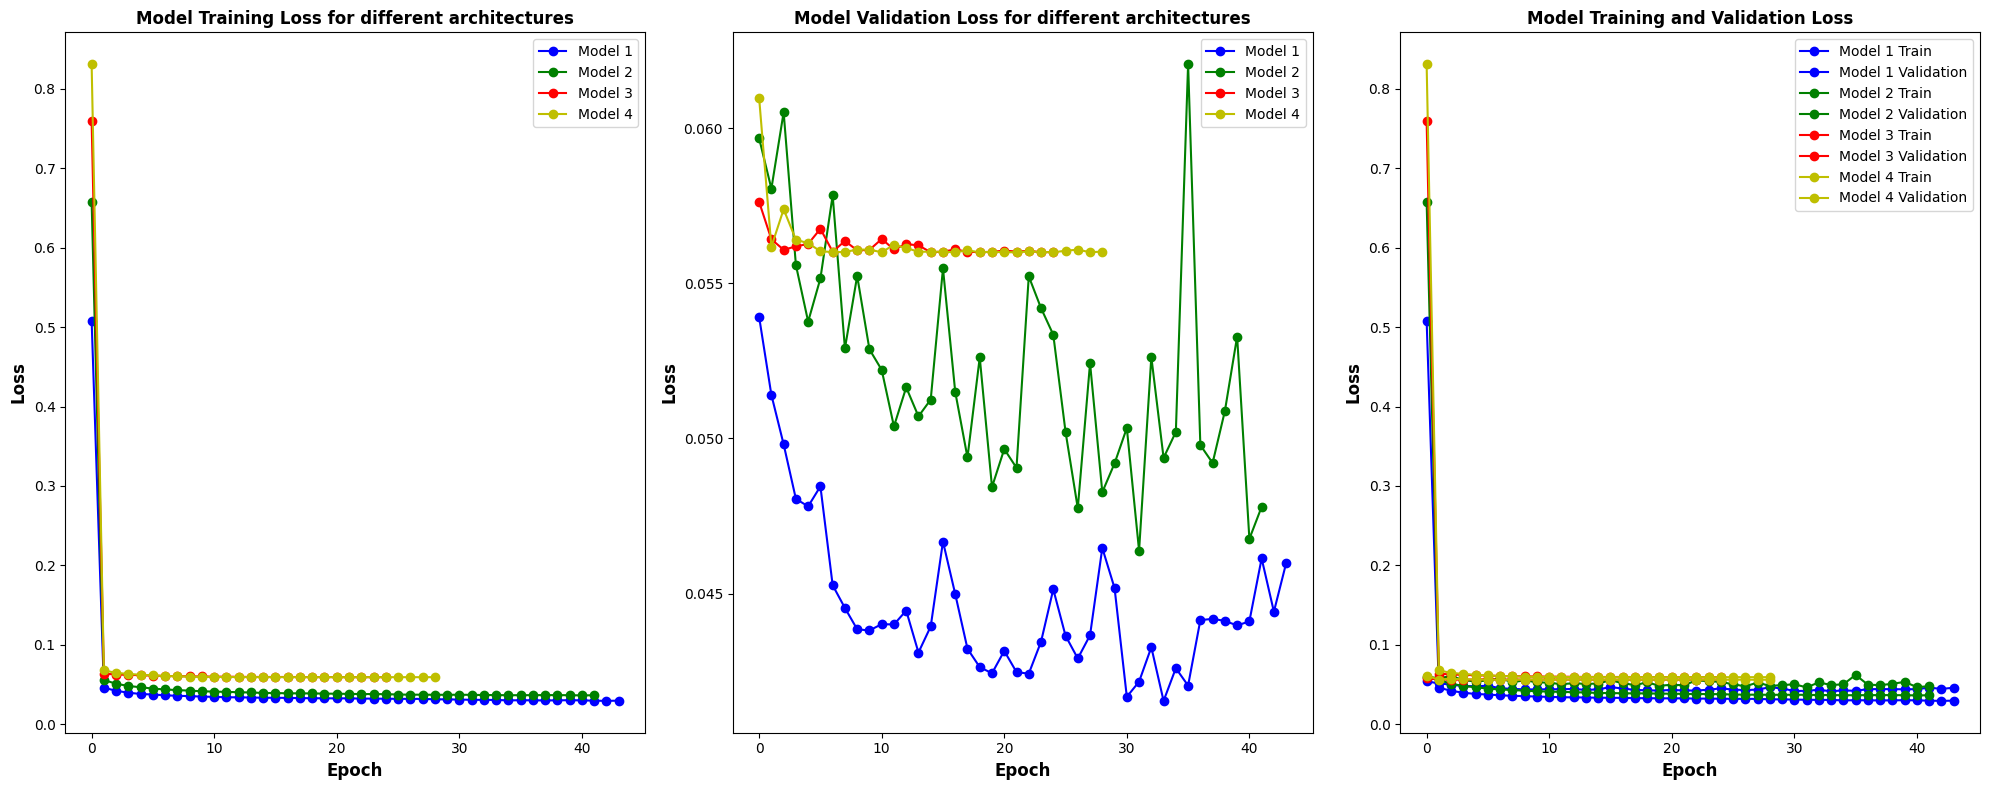

Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size


In [117]:
# Visualize training and validation loss for all models
plt.figure(figsize=(20, 8))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Training Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Validation Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['val_loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['val_loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['val_loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['val_loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Validation Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Plot validation and training loss on same plot
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Model 1 Train', marker='o', color = 'b')
plt.plot(history.history['val_loss'], label='Model 1 Validation', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2 Train', marker='o', color = 'g')
plt.plot(history2.history['val_loss'], label='Model 2 Validation', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3 Train', marker='o', color = 'r')
plt.plot(history3.history['val_loss'], label='Model 3 Validation', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4 Train', marker='o', color = 'y')
plt.plot(history4.history['val_loss'], label='Model 4 Validation', marker='o', color = 'y')
plt.title('Model Training and Validation Loss', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print models
print("Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")


### Hyperparameter Tuning / Grid Search

In [ ]:
import itertools

# Grid Search Parameters
n_layers = [1,2,3,6,8] 
n_nodes = [128,256,512,1024] 
optimizer = ['adam', 'sgd']
epochs = [50,150,300] 
learning_rate = [0.001, 0.01,  0.0001] 
batch_size = [32,64,128] 
dropout = [0, 0.01, 0.05, 0.08]
l2 = [0.01, 0.001, 0.0001]

# print(f"Number of combinations: {len(n_layers) * len(n_nodes) * len(optimizer) * len(epochs) * len(learning_rate) * len(batch_size)* len(dropout)* len(l2)}")

def grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout_val, l2_val, train_x, train_y):
    # Initialize best parameters and best model variables
    best_params = None
    best_model = None
    best_score = None

    # Generate all possible combinations of hyperparameters
    param_combinations = itertools.product(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout_val, l2_val)

    # Loop through all combinations
    for combination in param_combinations:
        # Unpack the combination
        n_layer, n_node, opt, epoch, lr, bs, dropout_val, l2_val = combination
        print(combination)

        # Train the model
        model, history = train_model_2(n_layers=n_layer, n_nodes=n_node, optimizer=opt, epochs=epoch, learning_rate=lr, batch_size=bs, dropout=dropout_val, l2_reg=l2_val, train_x=train_x, train_y=train_y, train_plot=False, seed=10, text_embedding_dim = text_embeddings.shape[1]-3, callback=True)

        # Evaluate the model
        min_loss = min(history.history['val_loss'])

        # Check if this model is better than the previous best
        if best_score is None or min_loss < best_score:
            best_score = min_loss
            best_params = combination
            best_model = model

    return best_params, best_model


# run grid search
best_params, best_model = grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout_val, l2_val, train_x, train_y)
print(f"Best Parameters: {best_params}")

Epoch 1/50
508/508 [==============================] - 5s 9ms/step - loss: 0.5191 - val_loss: 0.0548
Epoch 2/50
508/508 [==============================] - 4s 8ms/step - loss: 0.0526 - val_loss: 0.0524
Epoch 3/50
508/508 [==============================] - 4s 8ms/step - loss: 0.0481 - val_loss: 0.0533
Epoch 4/50
508/508 [==============================] - 4s 8ms/step - loss: 0.0457 - val_loss: 0.0499
Epoch 5/50
508/508 [==============================] - 3s 7ms/step - loss: 0.0435 - val_loss: 0.0504
Epoch 6/50
508/508 [==============================] - 4s 7ms/step - loss: 0.0426 - val_loss: 0.0485
Epoch 7/50
508/508 [==============================] - 4s 7ms/step - loss: 0.0412 - val_loss: 0.0513
Epoch 8/50
508/508 [==============================] - 3s 7ms/step - loss: 0.0406 - val_loss: 0.0520
Epoch 9/50
508/508 [==============================] - 4s 7ms/step - loss: 0.0405 - val_loss: 0.0486
Epoch 10/50
508/508 [==============================] - 4s 7ms/step - loss: 0.0397 - val_loss: 0.0473

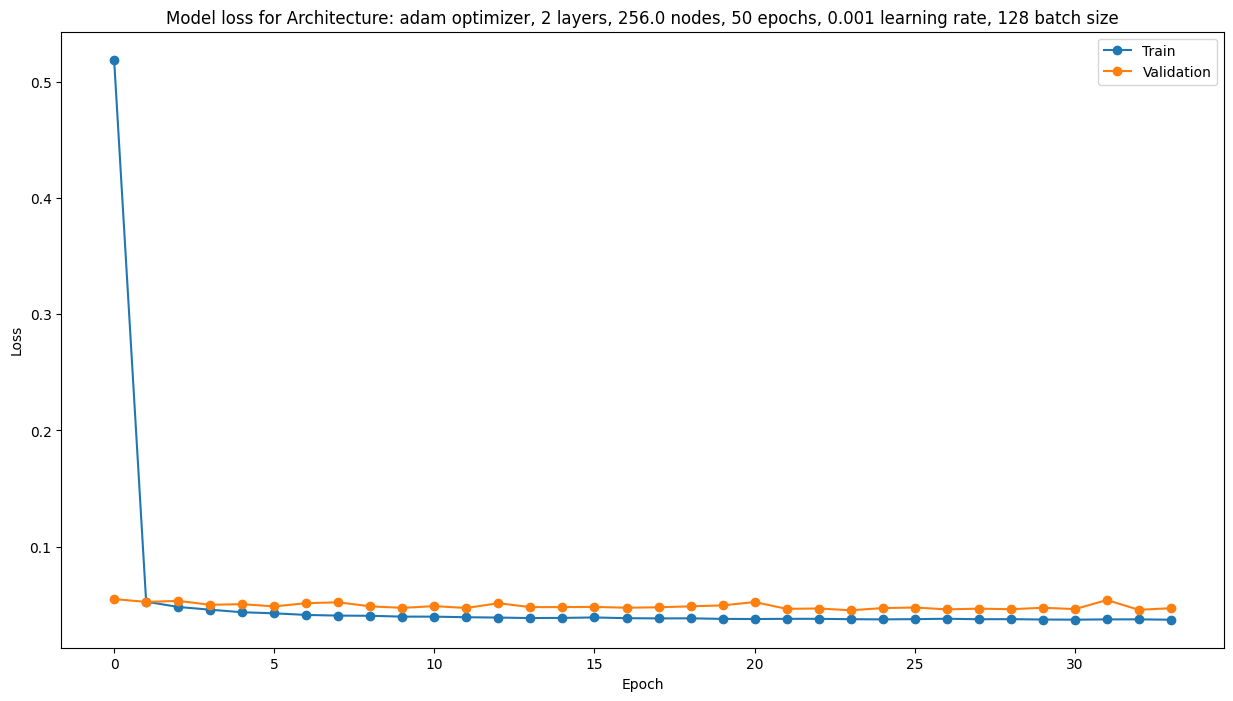

In [9]:
# fit best model 
best_model, history = train_model_2(n_layers=best_params[0], n_nodes=best_params[1], optimizer=best_params[2], epochs=best_params[3], learning_rate=best_params[4], batch_size=best_params[5], dropout=best_params[6], l2_reg=best_params[7], train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, train_plot=True, callback=True, seed=10)

### Evaluation

In [14]:
# MODEL EVALUATION ====================================
# Predict the ratings
# y_pred = best_model.predict([test_x['user'], test_x['product'], test_x.iloc[:, 2:]])
y_pred = model.predict([test_x['user'], test_x['product'], test_x.iloc[:, 2:]])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# save results to csv
results = pd.DataFrame({'MAE': [mae.round(3)], 'MSE': [mse.round(3)], 'RMSE': [rmse.round(3)]}) 
# results.to_csv(r"/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/Results/NCF_results_2.csv", index=False)
results

344/344 [==============================] - 1s 2ms/step

Rating Metrics
Mean Absolute Error (MAE): 0.5048669213297063
Mean Squared Error (MSE): 0.6324308431542174
Root Mean Squared Error (RMSE): 0.7952552063043771


,MAE,MSE,RMSE
0,0.505,0.632,0.795


Shapiro-Wilk test statistic: 0.8861603705321404
p-value: 7.01500268804892e-67


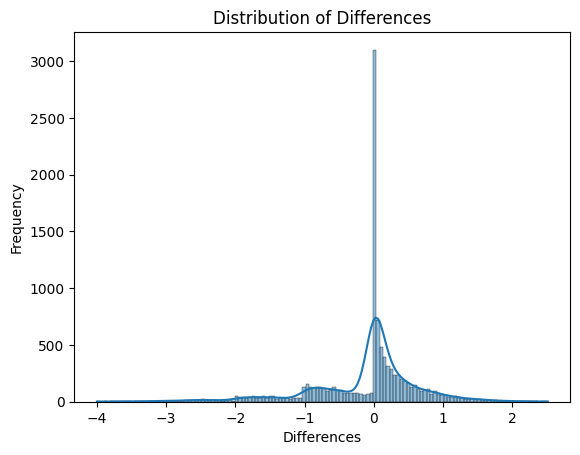

In [15]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming hidden_ratings_array and predicted_ratings_array are NumPy arrays containing the respective data

# Get differences
differences = hidden_ratings_array - predicted_ratings_array

# Check for normality using Shapiro-Wilk test
normality_test_statistic, p_value = stats.shapiro(differences)
print("Shapiro-Wilk test statistic:", normality_test_statistic)
print("p-value:", p_value)

# Visualize distribution of differences
sns.histplot(differences, kde=True)
plt.title('Distribution of Differences')
plt.xlabel('Differences')
plt.ylabel('Frequency')
plt.show()

In [31]:
from scipy.stats import kruskal

rmse_values = {
    'Item-Based Collaborative Filtering': 921323.861,
    'User-Based Collaborative Filtering': 2.992,
    'Non-Negative Matrix Factorisation': 100.862,
    'Neural Collaborative Filtering (Ratings Only)': 21212.903,
    'Neural Collaborative Filtering (Ratings & Reviews)': 0.01,
    'Neural Collaborative Filtering (Ratings, Reviews, Sentiments)': 33233.779,
    'Baseline Model': 1.311
}

# Perform Kruskal-Wallis test
h_statistic, p_value_kruskal = kruskal(*rmse_values.values())

print("Kruskal-Wallis p-value:", p_value_kruskal)

Kruskal-Wallis p-value: 0.42319008112684364


### Additional Accuracy Insights

1. Want to see if accuracy is better for users who have rated more items. (i.e., for users who have rated more items, is the accuracy of the model better?)

2. Want to see if accuracy is better for items that have been rated more times. (i.e., for items that have been rated more times, is the accuracy of the model better?)

3. Want to see if accuracy is better for some product categories. (i.e., for some product categories, is the accuracy of the model better?)
- TOO FEW REVIEWS PER CATEGORY
- RESULTS WOULD NOT OFFER MUCH INSIGHT

4. Want to see if accuracy is better for reviews that are longer. (i.e., for reviews that are longer, is the accuracy of the model better?)


Effectively, we want to see if accuracy varies according to some variables X or Y.

#### QUESTION 1

In [15]:
###### QUESTION 1: PROCESS
# 1. Group Users by the Number of Rated Items: Count the number of rated items for each user in your dataset.

# Count the number of rated items for each user
user_ratings = train_x.groupby('user')['product'].count().reset_index()
user_ratings.columns = ['user', 'n_rated_items']

# 2. Divide Users into Groups: Divide users into groups based on the number of rated items. You can define these groups based on quartiles, for example, or any other criteria that make sense for your dataset.

# Divide users into groups based on the number of rated items
user_ratings['group'] = pd.qcut(user_ratings['n_rated_items'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
display(user_ratings)

# what are the number of users in each group?
print(f'Number of Users in Low Group: {user_ratings[user_ratings["group"] == "Low"].shape[0]}')
print(f'Number of Users in Medium Group: {user_ratings[user_ratings["group"] == "Medium"].shape[0]}')
print(f'Number of Users in High Group: {user_ratings[user_ratings["group"] == "High"].shape[0]}')
print(f'Number of Users in Very High Group: {user_ratings[user_ratings["group"] == "Very High"].shape[0]}')

# 3. Evaluate the Model for Each Group: Evaluate the model for each group of users. You can use the same metrics you used in the previous question.
low_group = user_ratings[user_ratings['group'] == 'Low']
medium_group = user_ratings[user_ratings['group'] == 'Medium']
high_group = user_ratings[user_ratings['group'] == 'High']
very_high_group = user_ratings[user_ratings['group'] == 'Very High']

# get test set items for these groups
low_group_test = test_x[test_x['user'].isin(low_group['user'])]
medium_group_test = test_x[test_x['user'].isin(medium_group['user'])]
high_group_test = test_x[test_x['user'].isin(high_group['user'])]
very_high_group_test = test_x[test_x['user'].isin(very_high_group['user'])]

,user,n_rated_items,group
0,0,37,Very High
1,1,43,Very High
2,2,15,Medium
3,3,37,Very High
4,4,14,Medium
...,...,...,...
3663,3663,31,Very High
3664,3664,11,Low
3665,3665,12,Low
3666,3666,19,High


Number of Users in Low Group: 1271
Number of Users in Medium Group: 720
Number of Users in High Group: 764
Number of Users in Very High Group: 913


In [16]:
# get test set ratings for these groups
test_y_reset = test_y.reset_index(drop=True)
low_group_ratings = test_y_reset[test_x['user'].isin(low_group['user'])]
medium_group_ratings = test_y_reset[test_x['user'].isin(medium_group['user'])]
high_group_ratings = test_y_reset[test_x['user'].isin(high_group['user'])]
very_high_group_ratings = test_y_reset[test_x['user'].isin(very_high_group['user'])]


In [17]:

# get predictions for these groups
low_group_pred = y_pred[test_x['user'].isin(low_group['user'])]
medium_group_pred = y_pred[test_x['user'].isin(medium_group['user'])]
high_group_pred = y_pred[test_x['user'].isin(high_group['user'])]
very_high_group_pred = y_pred[test_x['user'].isin(very_high_group['user'])]

# set predictions and actual ratings to variables
low_group_ratings_array = (np.array(low_group_ratings)*4 + 1)
low_group_pred_array = np.array(low_group_pred).flatten()

medium_group_ratings_array = (np.array(medium_group_ratings)*4 + 1)
medium_group_pred_array = np.array(medium_group_pred).flatten()

high_group_ratings_array = (np.array(high_group_ratings)*4 + 1)
high_group_pred_array = np.array(high_group_pred).flatten()

very_high_group_ratings_array = (np.array(very_high_group_ratings)*4 + 1)
very_high_group_pred_array = np.array(very_high_group_pred).flatten()

# Rating predictions
low_group_mae = mean_absolute_error(low_group_ratings_array, low_group_pred_array)
low_group_mse = mean_squared_error(low_group_ratings_array, low_group_pred_array)
low_group_rmse = np.sqrt(low_group_mse)

medium_group_mae = mean_absolute_error(medium_group_ratings_array, medium_group_pred_array)
medium_group_mse = mean_squared_error(medium_group_ratings_array, medium_group_pred_array)
medium_group_rmse = np.sqrt(medium_group_mse)

high_group_mae = mean_absolute_error(high_group_ratings_array, high_group_pred_array)
high_group_mse = mean_squared_error(high_group_ratings_array, high_group_pred_array)    
high_group_rmse = np.sqrt(high_group_mse)

very_high_group_mae = mean_absolute_error(very_high_group_ratings_array, very_high_group_pred_array)
very_high_group_mse = mean_squared_error(very_high_group_ratings_array, very_high_group_pred_array)
very_high_group_rmse = np.sqrt(very_high_group_mse)

# display results
print("Checking if the number of reviews impact the model performance.")
results = pd.DataFrame({'MAE': [low_group_mae.round(3), medium_group_mae.round(3), high_group_mae.round(3), very_high_group_mae.round(3)], 'MSE': [low_group_mse.round(3), medium_group_mse.round(3), high_group_mse.round(3), very_high_group_mse.round(3)], 'RMSE': [low_group_rmse.round(3), medium_group_rmse.round(3), high_group_rmse.round(3), very_high_group_rmse.round(3)]})
results.index = ['Low', 'Medium', 'High', 'Very High']
print(f'Number of Users in Low Group: {low_group.shape[0]}')
print(f'Number of Users in Medium Group: {medium_group.shape[0]}')
print(f'Number of Users in High Group: {high_group.shape[0]}')
print(f'Number of Users in Very High Group: {very_high_group.shape[0]}')
results

Checking if the number of reviews impact the model performance.
Number of Users in Low Group: 1271
Number of Users in Medium Group: 720
Number of Users in High Group: 764
Number of Users in Very High Group: 913


,MAE,MSE,RMSE
Low,0.498,0.635,0.797
Medium,0.459,0.562,0.750
High,0.532,0.687,0.829
Very High,0.528,0.638,0.799


In [18]:
# evaluate the performance of model for each user
for user in range(user_ratings.shape[0]):
    user = user_ratings['user'][user]
    # get test set items for user
    user_test = test_x[test_x['user'] == user]
    # get test set ratings for user
    users_ratings = test_y_reset[test_x['user'] == user]
    # get predictions for user
    user_pred = y_pred[test_x['user'] == user]
    # set predictions and actual ratings to variables
    user_ratings_array = (np.array(users_ratings)*4 + 1)
    user_pred_array = np.array(user_pred).flatten()
    # Rating predictions
    user_mae = mean_absolute_error(user_ratings_array, user_pred_array)
    user_mse = mean_squared_error(user_ratings_array, user_pred_array)
    user_rmse = np.sqrt(user_mse)
    # assing results to user_ratings
    user_ratings.loc[user, 'MAE'] = user_mae
    user_ratings.loc[user, 'MSE'] = user_mse
    user_ratings.loc[user, 'RMSE'] = user_rmse

In [19]:
user_ratings

,user,n_rated_items,group,MAE,MSE,RMSE
0,0,37,Very High,0.663171,1.296717,1.138735
1,1,43,Very High,0.755829,0.795317,0.891806
2,2,15,Medium,0.049880,0.002950,0.054314
3,3,37,Very High,0.237028,0.112613,0.335579
4,4,14,Medium,0.008502,0.000074,0.008574
...,...,...,...,...,...,...
3663,3663,31,Very High,0.450804,0.230140,0.479729
3664,3664,11,Low,0.949487,1.399501,1.183005
3665,3665,12,Low,0.584946,0.423848,0.651036
3666,3666,19,High,0.260162,0.074167,0.272336


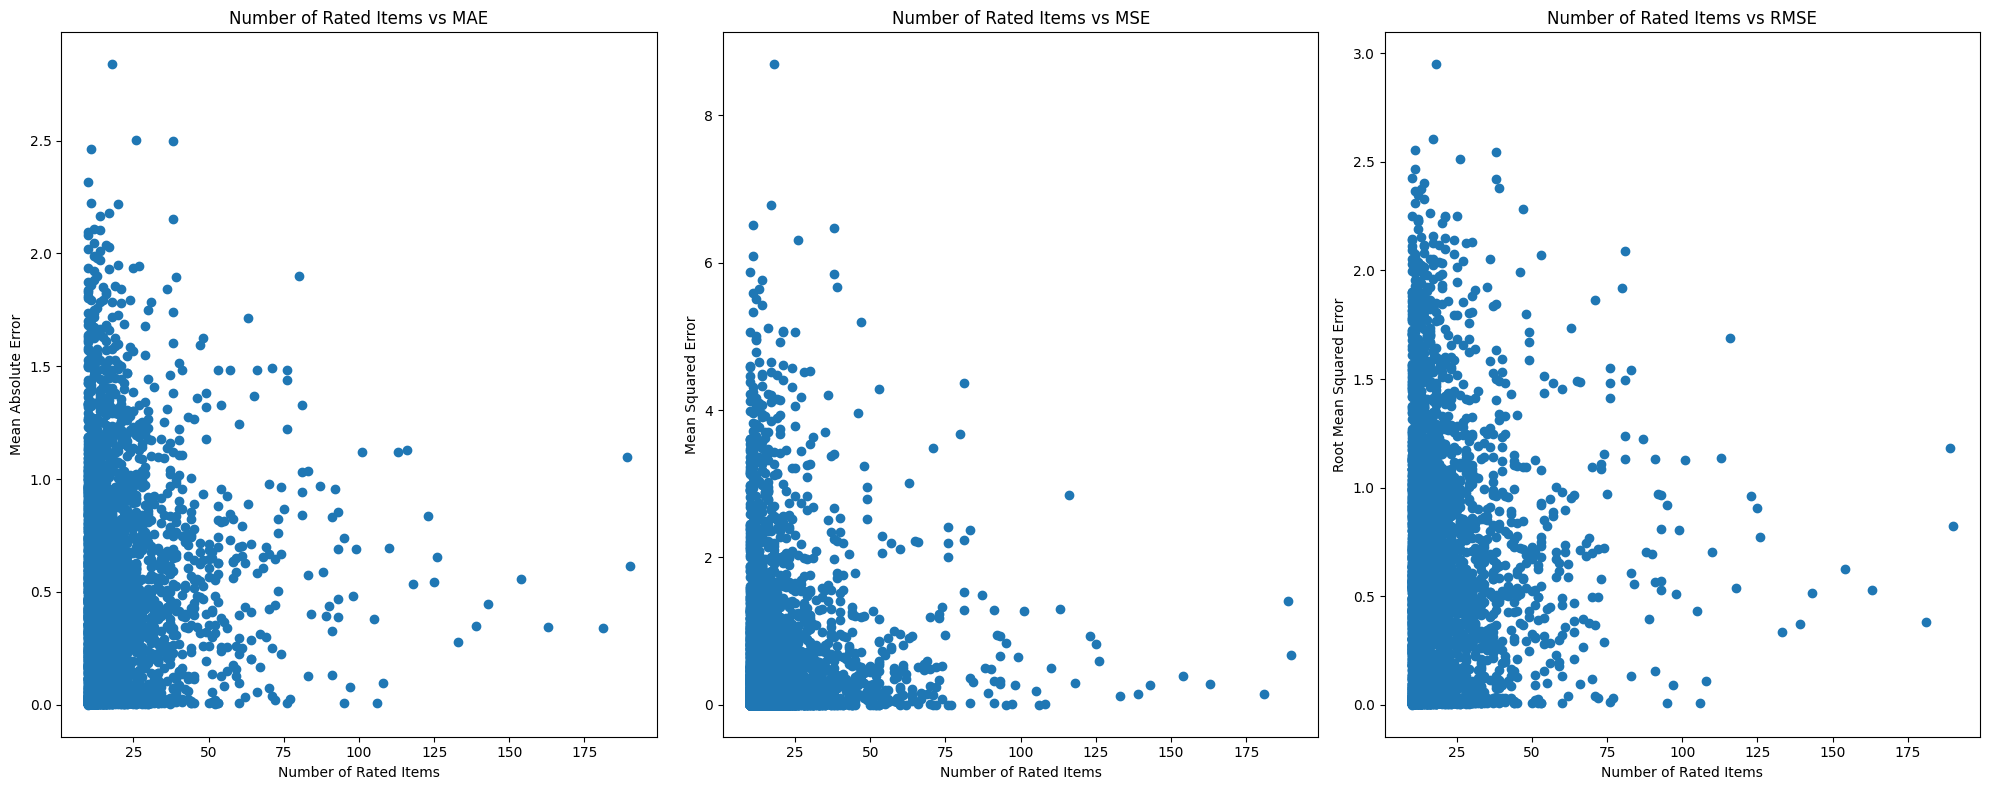

In [20]:
# 4. Visualize the Results: Plot the accuracy metrics (RMSE, MSE, MAE) against the number of rated items for each group. This will help you visualize any patterns or trends in the accuracy of your model based on the number of rated items.
## plot number of rated items vs MAE, MSE, RMSE scatter plot
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.scatter(user_ratings['n_rated_items'], user_ratings['MAE'])
plt.title('Number of Rated Items vs MAE')
plt.xlabel('Number of Rated Items')
plt.ylabel('Mean Absolute Error')

plt.subplot(1, 3, 2)
plt.scatter(user_ratings['n_rated_items'], user_ratings['MSE'])
plt.title('Number of Rated Items vs MSE')
plt.xlabel('Number of Rated Items')
plt.ylabel('Mean Squared Error')

plt.subplot(1, 3, 3)
plt.scatter(user_ratings['n_rated_items'], user_ratings['RMSE'])
plt.title('Number of Rated Items vs RMSE')
plt.xlabel('Number of Rated Items')
plt.ylabel('Root Mean Squared Error')
plt.tight_layout()
plt.show()


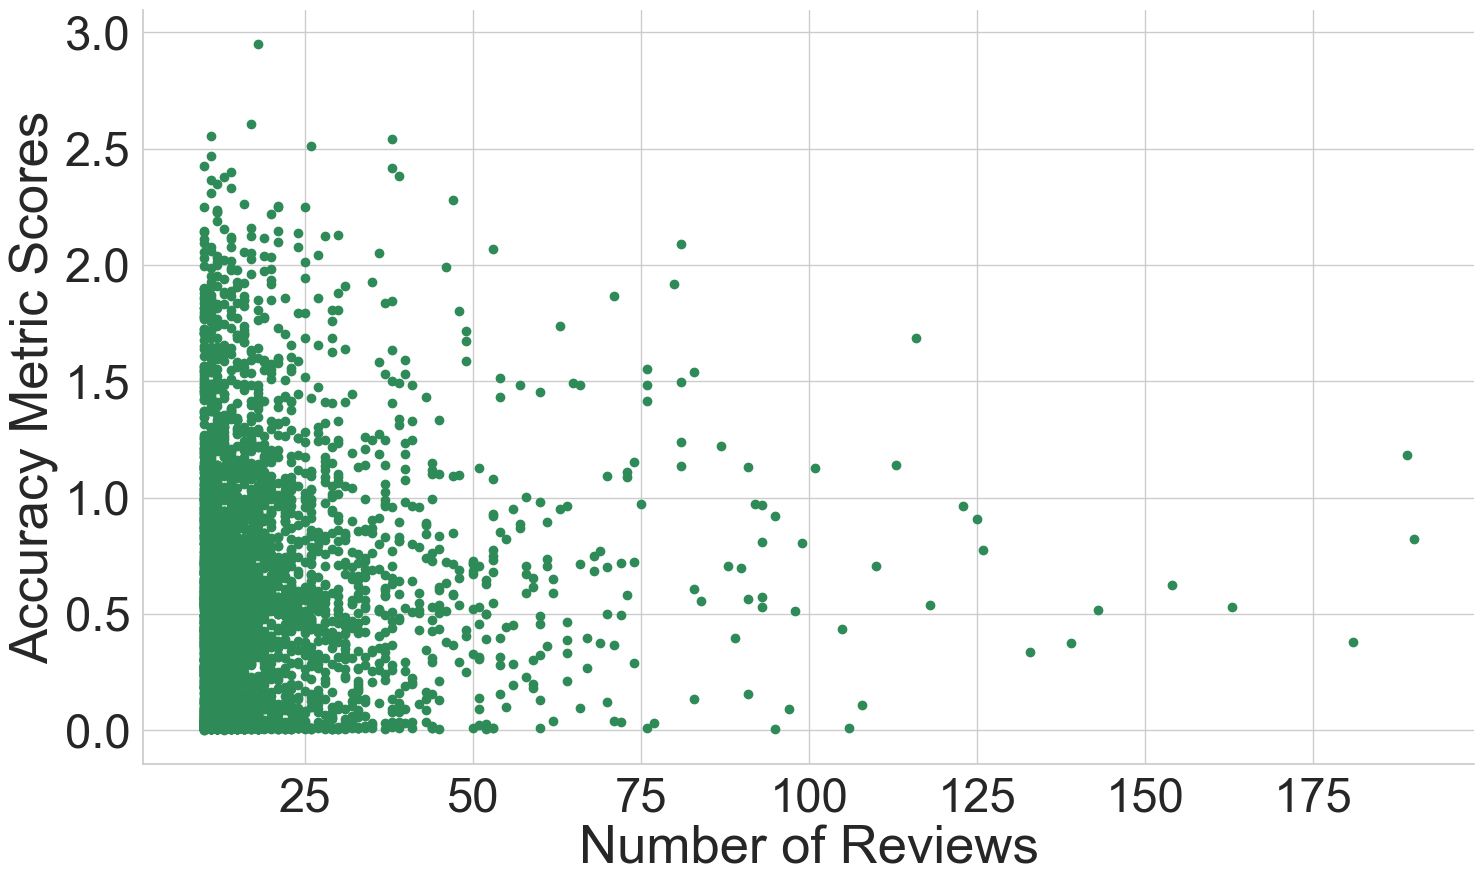

In [21]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Create a colormap for different accuracy metrics
colors = {'RMSE': 'seagreen'}

# 4. Visualize the Results: Plot the accuracy metrics (RMSE, MSE, MAE) against the number of rated items for each group.
# Plot number of rated items vs MAE, MSE, RMSE scatter plot
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(15, 9))

# Iterate over each accuracy metric
for metric in ['RMSE']:
    plt.scatter(user_ratings['n_rated_items'], user_ratings[metric], c=colors[metric], label=metric)

plt.xlabel('Number of Reviews', fontsize=38)
plt.ylabel('Accuracy Metric Scores', fontsize=38)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
sns.despine()
plt.tight_layout()
plt.savefig("/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Final Writing/Figures/ncf_user_ratings_metrics.pdf")
plt.grid(True)
plt.show()


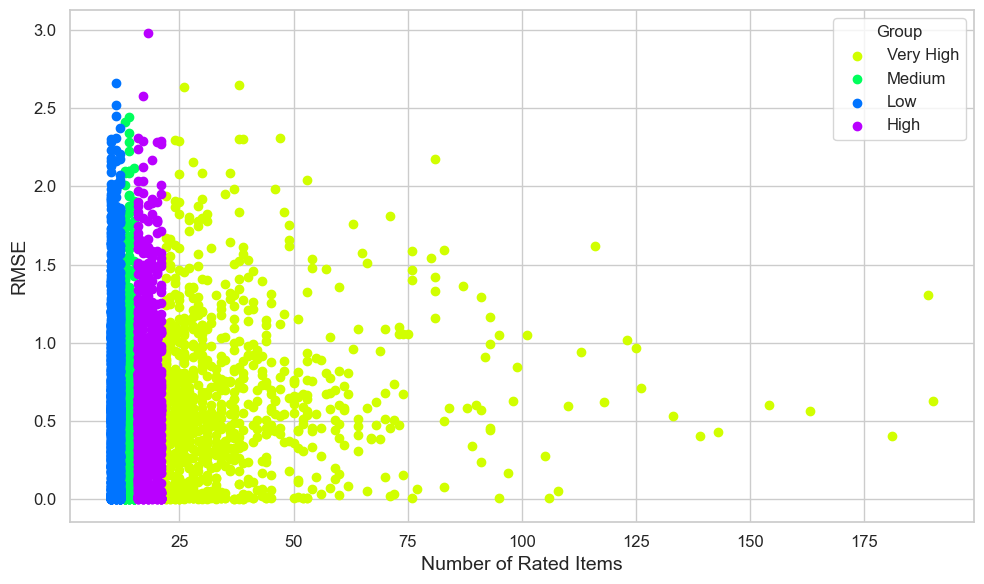

In [41]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create a colormap for different groups
palette = sns.color_palette("hsv", len(user_ratings['group'].unique()))

# 4. Visualize the Results: Plot the RMSE against the number of rated items for each group.
# Plot number of rated items vs RMSE scatter plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Iterate over each group
for i, group in enumerate(user_ratings['group'].unique()):
    group_data = user_ratings[user_ratings['group'] == group]
    plt.scatter(group_data['n_rated_items'], group_data['RMSE'], color=palette[i], label=group)

plt.xlabel('Number of Rated Items', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.legend(title='Group', fontsize=12)
plt.title('', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# get the quartiles 
user_ratings['n_rated_items'].describe()

count    3668.000000
mean       19.666031
std        15.043323
min        10.000000
25%        12.000000
50%        15.000000
75%        21.000000
max       190.000000
Name: n_rated_items, dtype: float64

In [23]:
# see summary statistics for each group
tab = user_ratings.groupby('group').agg({'MAE': ['mean'], 'MSE': ['mean'], 'RMSE': ['mean',]}).round(3)
display(tab)
tab['quartiles'] = ['0-12', '13-15', '16-21', '21-' ]
tab = tab[['quartiles', 'MAE', 'MSE', 'RMSE']]

import tabulate
latex_table = tabulate.tabulate(tab, headers='keys', tablefmt='latex_raw', showindex=False)
print(latex_table)


,MAE,MSE,RMSE
,mean,mean,mean
group,,,
Low,0.498,0.635,0.598
Medium,0.459,0.562,0.554
High,0.532,0.687,0.640
Very High,0.528,0.638,0.628


\begin{tabular}{lrrr}
\hline
 ('quartiles', '')   &   ('MAE', 'mean') &   ('MSE', 'mean') &   ('RMSE', 'mean') \\
\hline
 0-12                &             0.498 &             0.635 &              0.598 \\
 13-15               &             0.459 &             0.562 &              0.554 \\
 16-21               &             0.532 &             0.687 &              0.64  \\
 21-                 &             0.528 &             0.638 &              0.628 \\
\hline
\end{tabular}


In [62]:
# apply kruskal wallis test
from scipy.stats import kruskal

# Perform Kruskal-Wallis test
h_statistic, p_value_kruskal = kruskal(low_group_rmse, medium_group_rmse, high_group_rmse, very_high_group_rmse)
print("Kruskal-Wallis p-value:", p_value_kruskal)


Kruskal-Wallis p-value: 0.3916251762710877


In [58]:

# apply anova test
import scipy.stats as stats
f_val, p_val = stats.f_oneway(user_ratings[user_ratings['group'] == 'Low']['RMSE'], user_ratings[user_ratings['group'] == 'Medium']['RMSE'], user_ratings[user_ratings['group'] == 'High']['RMSE'], user_ratings[user_ratings['group'] == 'Very High']['RMSE'])
print(f'F-Value: {f_val}')
print(f'P-Value: {p_val}')

# apply post-hoc test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(user_ratings['RMSE'], user_ratings['group'])
result = mc.tukeayhsd()
print(result)

F-Value: 4.554401287781126
P-Value: 0.0034390352278697283
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj   lower   upper  reject
-------------------------------------------------------
  High       Low  -0.0461 0.2179 -0.1078  0.0155  False
  High    Medium  -0.0909 0.0047 -0.1608 -0.0209   True
  High Very High  -0.0134 0.9536 -0.0794  0.0526  False
   Low    Medium  -0.0447  0.259 -0.1075  0.0181  False
   Low Very High   0.0327 0.4746 -0.0257  0.0911  False
Medium Very High   0.0774  0.016  0.0103  0.1445   True
-------------------------------------------------------


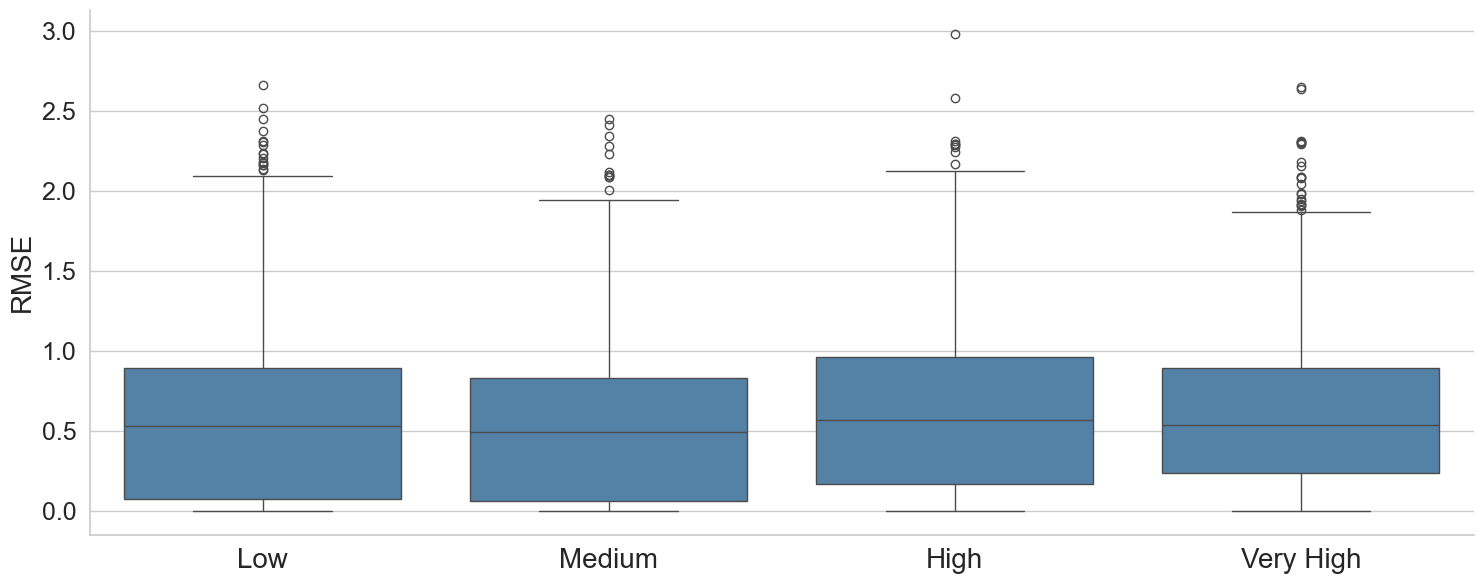

In [57]:
# use a boxplot to visualize the results
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(15, 6))
sns.boxplot(x='group', y='RMSE', data=user_ratings, color = 'steelblue')
plt.xlabel('', fontsize=1)
plt.ylabel('RMSE', fontsize=20)
plt.title('', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig("/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Final Writing/Figures/ncf_groupUser_ratings_metrics.pdf")
plt.show()


#### QUESTION 2

In [24]:
# QUESTION 2: Want to see if accuracy is better for items that have been rated more times. (i.e., for items that have been rated more times, is the accuracy of the model better?)

# Count the number of ratings for each item
item_ratings = train_x.groupby('product')['user'].count().reset_index()
item_ratings.columns = ['product', 'n_ratings']

# Divide items into groups based on the number of ratings
item_ratings['group'] = pd.qcut(item_ratings['n_ratings'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Evaluate the model for each group of items
low_group = item_ratings[item_ratings['group'] == 'Low']
medium_group = item_ratings[item_ratings['group'] == 'Medium']
high_group = item_ratings[item_ratings['group'] == 'High']
very_high_group = item_ratings[item_ratings['group'] == 'Very High']

# get test set items for these groups
low_group_test = test_x[test_x['product'].isin(low_group['product'])]
medium_group_test = test_x[test_x['product'].isin(medium_group['product'])]
high_group_test = test_x[test_x['product'].isin(high_group['product'])]
very_high_group_test = test_x[test_x['product'].isin(very_high_group['product'])]

# get test set ratings for these groups
low_group_ratings = test_y_reset[test_x['product'].isin(low_group['product'])]
medium_group_ratings = test_y_reset[test_x['product'].isin(medium_group['product'])]
high_group_ratings = test_y_reset[test_x['product'].isin(high_group['product'])]
very_high_group_ratings = test_y_reset[test_x['product'].isin(very_high_group['product'])]

# get predictions for these groups
low_group_pred = y_pred[test_x['product'].isin(low_group['product'])]
medium_group_pred = y_pred[test_x['product'].isin(medium_group['product'])]
high_group_pred = y_pred[test_x['product'].isin(high_group['product'])]
very_high_group_pred = y_pred[test_x['product'].isin(very_high_group['product'])]

# set predictions and actual ratings to variables
low_group_ratings_array = (np.array(low_group_ratings)*4 + 1)
low_group_pred_array = np.array(low_group_pred).flatten()

medium_group_ratings_array = (np.array(medium_group_ratings)*4 + 1)
medium_group_pred_array = np.array(medium_group_pred).flatten()

high_group_ratings_array = (np.array(high_group_ratings)*4 + 1)
high_group_pred_array = np.array(high_group_pred).flatten()

very_high_group_ratings_array = (np.array(very_high_group_ratings)*4 + 1)
very_high_group_pred_array = np.array(very_high_group_pred).flatten()

# Rating predictions
low_group_mae = mean_absolute_error(low_group_ratings_array, low_group_pred_array)
low_group_mse = mean_squared_error(low_group_ratings_array, low_group_pred_array)
low_group_rmse = np.sqrt(low_group_mse)

medium_group_mae = mean_absolute_error(medium_group_ratings_array, medium_group_pred_array)
medium_group_mse = mean_squared_error(medium_group_ratings_array, medium_group_pred_array)
medium_group_rmse = np.sqrt(medium_group_mse)

high_group_mae = mean_absolute_error(high_group_ratings_array, high_group_pred_array)
high_group_mse = mean_squared_error(high_group_ratings_array, high_group_pred_array)
high_group_rmse = np.sqrt(high_group_mse)

very_high_group_mae = mean_absolute_error(very_high_group_ratings_array, very_high_group_pred_array)
very_high_group_mse = mean_squared_error(very_high_group_ratings_array, very_high_group_pred_array)
very_high_group_rmse = np.sqrt(very_high_group_mse)

# display results
print("Checking if the number of reviews of an impact the model performance for items.")
results = pd.DataFrame({'MAE': [low_group_mae.round(3), medium_group_mae.round(3), high_group_mae.round(3), very_high_group_mae.round(3)], 'MSE': [low_group_mse.round(3), medium_group_mse.round(3), high_group_mse.round(3), very_high_group_mse.round(3)], 'RMSE': [low_group_rmse.round(3), medium_group_rmse.round(3), high_group_rmse.round(3), very_high_group_rmse.round(3)]})
results.index = ['Low', 'Medium', 'High', 'Very High']
print(f'Number of Items in Low Group: {low_group.shape[0]}')
print(f'Number of Items in Medium Group: {medium_group.shape[0]}')
print(f'Number of Items in High Group: {high_group.shape[0]}')
print(f'Number of Items in Very High Group: {very_high_group.shape[0]}')
results

Checking if the number of reviews of an impact the model performance for items.
Number of Items in Low Group: 974
Number of Items in Medium Group: 672
Number of Items in High Group: 842
Number of Items in Very High Group: 761


,MAE,MSE,RMSE
Low,0.511,0.644,0.802
Medium,0.499,0.614,0.783
High,0.514,0.654,0.809
Very High,0.493,0.610,0.781


In [25]:
# evaluate the performance of model for each item
for item in item_ratings['product']:
    # Filter test set data for the current item
    item_test = test_x[test_x['product'] == item]
    if not item_test.empty:  # Check if there are samples available
        # Get test set ratings for the current item
        items_ratings = test_y_reset[test_x['product'] == item]
        # Get predictions for the current item
        item_pred = y_pred[test_x['product'] == item]
        # Set predictions and actual ratings to variables
        item_ratings_array = (np.array(items_ratings) * 4 + 1)
        item_pred_array = np.array(item_pred).flatten()
        # Rating predictions
        item_mae = mean_absolute_error(item_ratings_array, item_pred_array)
        item_mse = mean_squared_error(item_ratings_array, item_pred_array)
        item_rmse = np.sqrt(item_mse)
        # Assign results to item_ratings
        item_ratings.loc[item, 'MAE'] = item_mae
        item_ratings.loc[item, 'MSE'] = item_mse
        item_ratings.loc[item, 'RMSE'] = item_rmse
    else:
        # No samples available for this item
        print(f"No test set data available for item {item}. Skipping evaluation.")

No test set data available for item 2991. Skipping evaluation.
No test set data available for item 2992. Skipping evaluation.
No test set data available for item 2993. Skipping evaluation.
No test set data available for item 2994. Skipping evaluation.
No test set data available for item 2995. Skipping evaluation.
No test set data available for item 2996. Skipping evaluation.
No test set data available for item 2997. Skipping evaluation.
No test set data available for item 2998. Skipping evaluation.
No test set data available for item 2999. Skipping evaluation.
No test set data available for item 3000. Skipping evaluation.
No test set data available for item 3001. Skipping evaluation.
No test set data available for item 3002. Skipping evaluation.
No test set data available for item 3003. Skipping evaluation.
No test set data available for item 3004. Skipping evaluation.
No test set data available for item 3005. Skipping evaluation.
No test set data available for item 3006. Skipping eval

In [70]:
# how many nas in item_ratings
item_ratings.isna().sum()

#the test set items were randomly selected from the users' rated items list, there's a possibility that certain items may not have been included in the test set due to the random sampling process. As a result, when we attempt to evaluate the model's performance for each item using the test set, some items may not have any corresponding test set data available.

product        0
n_ratings      0
group          0
MAE          258
MSE          258
RMSE         258
dtype: int64

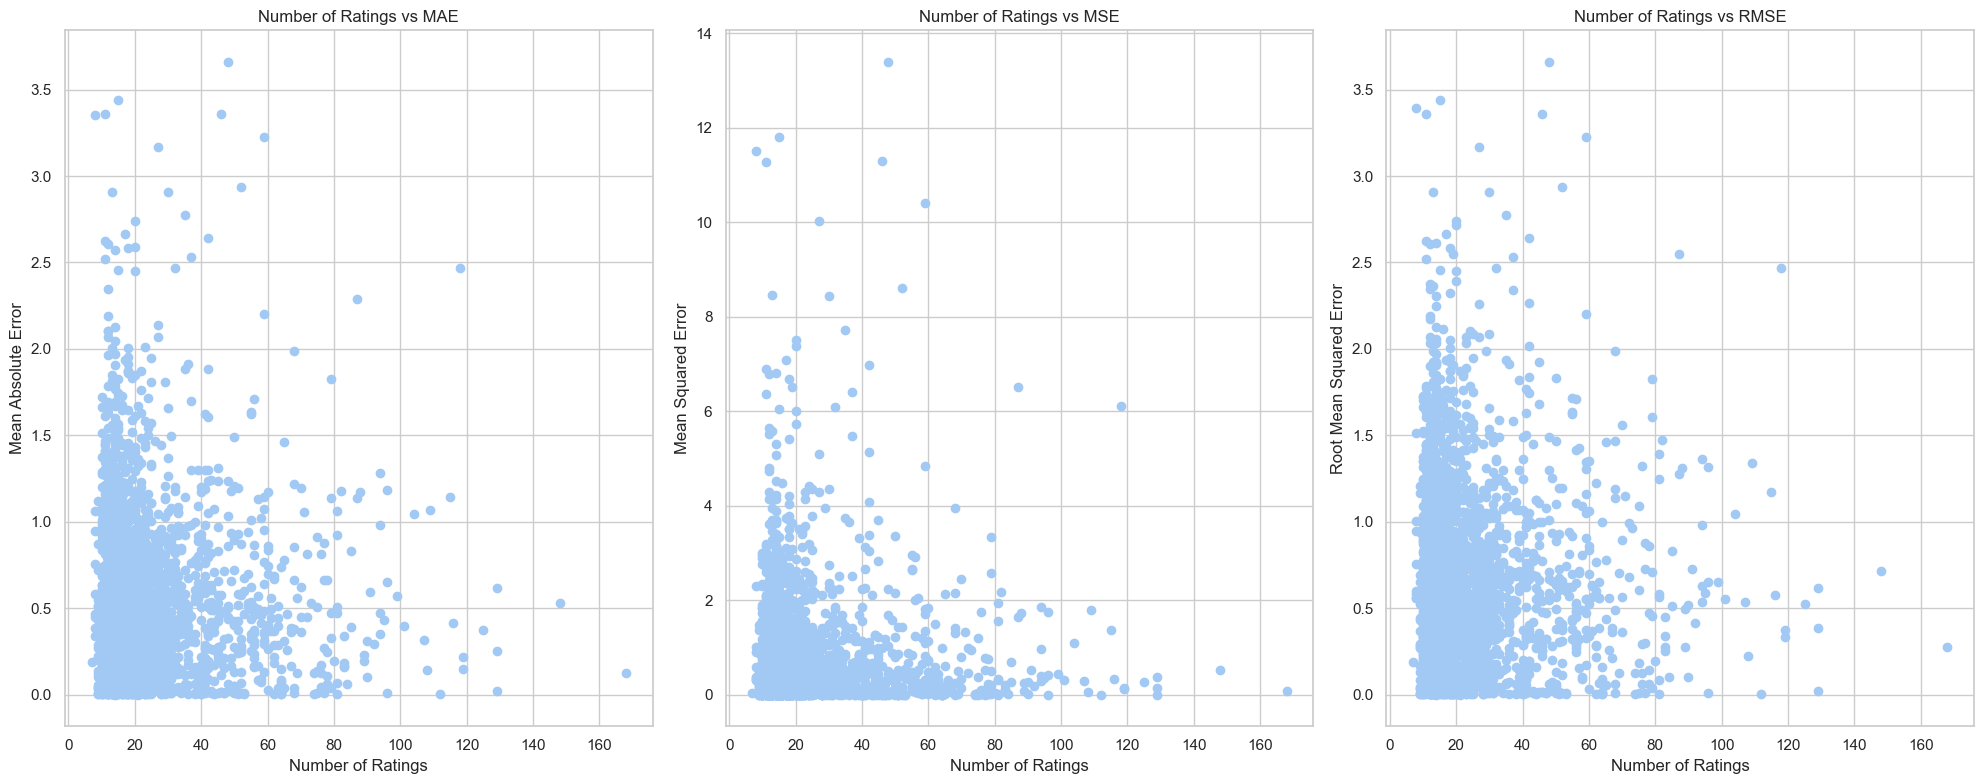

In [26]:
# 4. Visualize the Results: Plot the accuracy metrics (RMSE, MSE, MAE) against the number of reviews for each group. This will help you visualize any patterns or trends in the accuracy of your model based on the number of rated items.¸
## plot number of rated items vs MAE, MSE, RMSE scatter plot
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.scatter(item_ratings['n_ratings'], item_ratings['MAE'])
plt.title('Number of Ratings vs MAE')
plt.xlabel('Number of Ratings')
plt.ylabel('Mean Absolute Error')

plt.subplot(1, 3, 2)
plt.scatter(item_ratings['n_ratings'], item_ratings['MSE'])
plt.title('Number of Ratings vs MSE')
plt.xlabel('Number of Ratings')
plt.ylabel('Mean Squared Error')

plt.subplot(1, 3, 3)
plt.scatter(item_ratings['n_ratings'], item_ratings['RMSE'])
plt.title('Number of Ratings vs RMSE')
plt.xlabel('Number of Ratings')
plt.ylabel('Root Mean Squared Error')

plt.tight_layout()
plt.show()

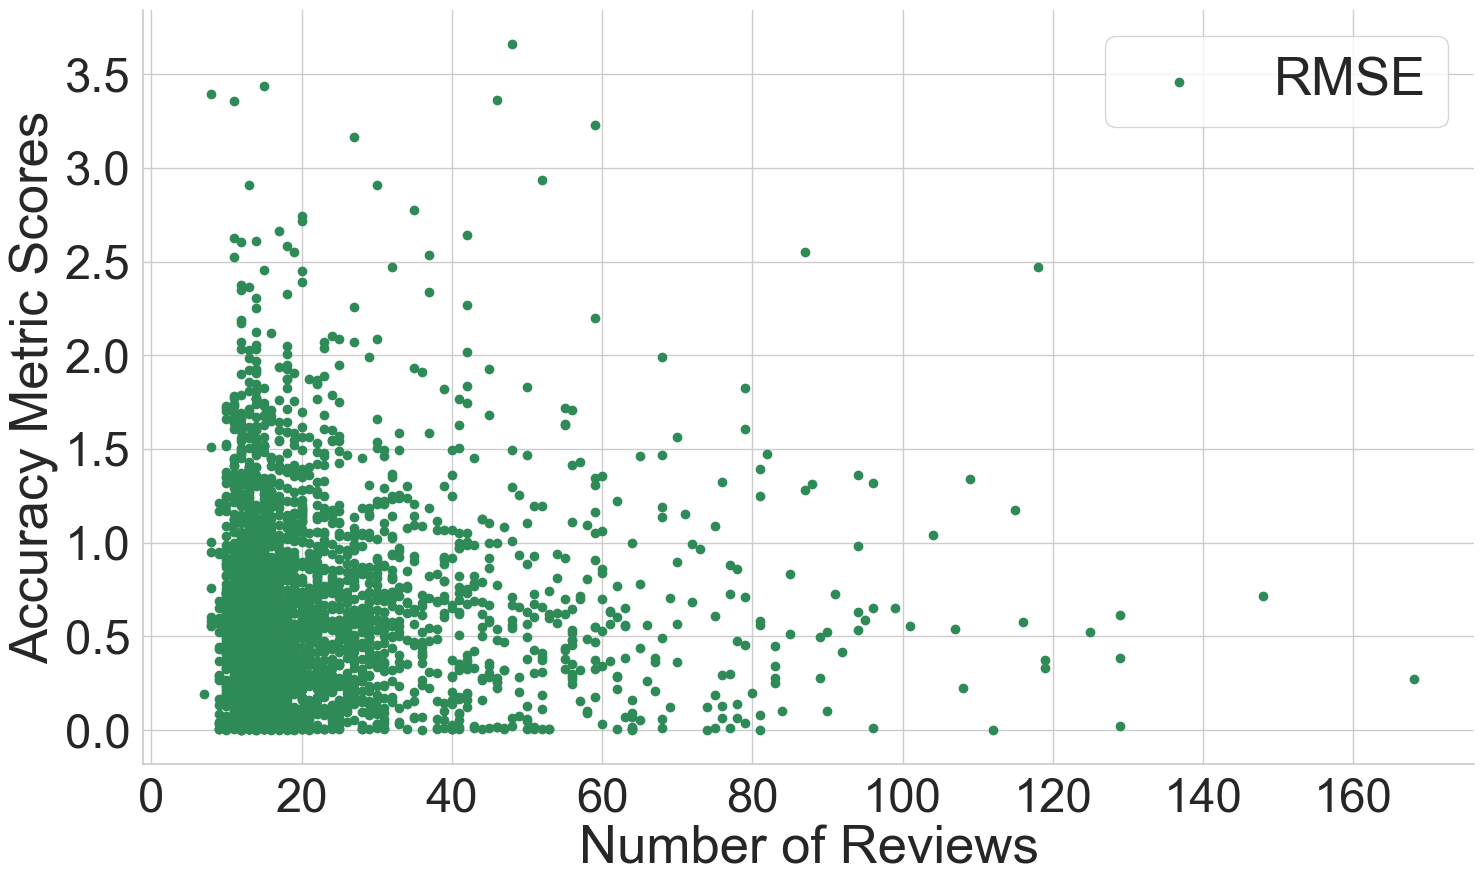

In [27]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Create a colormap for different accuracy metrics
colors = {'RMSE': 'seagreen'}

# 4. Visualize the Results: Plot the accuracy metrics (RMSE, MSE, MAE) against the number of rated items for each group.
# Plot number of rated items vs MAE, MSE, RMSE scatter plot
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(15, 9))

# Iterate over each accuracy metric
for metric in ['RMSE']:
    plt.scatter(item_ratings['n_ratings'], item_ratings[metric], c=colors[metric], label=metric)

plt.xlabel('Number of Reviews', fontsize=38)
plt.ylabel('Accuracy Metric Scores', fontsize=38)
plt.legend(fontsize=38)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
sns.despine()
plt.tight_layout()
plt.savefig("/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Final Writing/Figures/ncf_item_ratings_metrics.pdf")
plt.grid(True)
plt.show()


In [76]:
item_ratings['n_ratings'].describe()

count    3249.000000
mean       22.202216
std        16.006985
min         7.000000
25%        13.000000
50%        16.000000
75%        25.000000
max       168.000000
Name: n_ratings, dtype: float64

In [77]:
# see summary statistics for each group
tab = item_ratings.groupby('group').agg({'MAE': ['mean'], 'MSE': ['mean'], 'RMSE': ['mean',]}).round(3)
display(tab)
tab['quartiles'] = ['0-13', '14-16', '6-25', '26-' ]
tab = tab[['quartiles', 'MAE', 'MSE', 'RMSE']]

import tabulate
latex_table = tabulate.tabulate(tab, headers='keys', tablefmt='latex_raw', showindex=False)
print(latex_table)


,MAE,MSE,RMSE
,mean,mean,mean
group,,,
Low,0.526,0.681,0.652
Medium,0.518,0.659,0.638
High,0.519,0.671,0.644
Very High,0.523,0.705,0.644


\begin{tabular}{lrrr}
\hline
 ('quartiles', '')   &   ('MAE', 'mean') &   ('MSE', 'mean') &   ('RMSE', 'mean') \\
\hline
 0-13                &             0.526 &             0.681 &              0.652 \\
 14-16               &             0.518 &             0.659 &              0.638 \\
 6-25                &             0.519 &             0.671 &              0.644 \\
 26-                 &             0.523 &             0.705 &              0.644 \\
\hline
\end{tabular}


In [83]:
# see summary statistics for each group
display(item_ratings.groupby('group').agg({'MAE': ['mean', 'std'], 'MSE': ['mean', 'std'], 'RMSE': ['mean', 'std']}))

# apply anova test
item_ratings.dropna(inplace=True)
f_val, p_val = stats.f_oneway(item_ratings[item_ratings['group'] == 'Low']['RMSE'], item_ratings[item_ratings['group'] == 'Medium']['RMSE'], item_ratings[item_ratings['group'] == 'High']['RMSE'], item_ratings[item_ratings['group'] == 'Very High']['RMSE'])
print(f'F-Value: {f_val}')
print(f'P-Value: {p_val}')

# apply post-hoc test
item_ratings['RMSE'] = pd.to_numeric(item_ratings['RMSE'], errors='coerce')  # coerce errors to NaN if conversion fails
mc = MultiComparison(item_ratings['RMSE'], item_ratings['group'])
result = mc.tukeyhsd()
print(result)


MAE                 MSE                RMSE          
               mean       std      mean       std      mean       std
group                                                                
Low        0.525547  0.452610  0.681005  1.088684  0.652154  0.505957
Medium     0.517788  0.450958  0.659353  1.075723  0.637981  0.502741
High       0.519435  0.442837  0.671025  1.025433  0.644228  0.506288
Very High  0.522935  0.496137  0.705470  1.328402  0.644379  0.539112

F-Value: 0.0950151150079237
P-Value: 0.9628097651898144
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj   lower  upper  reject
------------------------------------------------------
  High       Low   0.0079 0.9894 -0.0572 0.0731  False
  High    Medium  -0.0062  0.996 -0.0778 0.0653  False
  High Very High   0.0002    1.0 -0.0679 0.0682  False
   Low    Medium  -0.0142 0.9537 -0.0839 0.0555  False
   Low Very High  -0.0078 0.9904 -0.0739 0.0583  False
Medium Very High   0.0064 0.9959  -0.066 0.0788  False
------------------------------------------------------


#### QUESTION 4

In [28]:
# 4. Want to see if accuracy is better for reviews that are longer. (i.e., for reviews that are longer, is the accuracy of the model better?)
train_x_extd = pd.merge(data_hidden, text_embeddings[['revText', 'reviewerID', 'asin']], how='outer', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
train_x_extd.drop(['asin','reviewerID'], axis=1, inplace=True)
train_x_extd = train_x_extd[train_x_extd['rating'].notna()]
train_x_extd['user'] = train_x_extd['user'].astype('category')
train_x_extd['product'] = train_x_extd['product'].astype('category')
train_x_extd.set_index(data_hidden.index, inplace=True)
train_x_extd[['user', 'product']] = train_x_extd[['user', 'product']].apply(lambda x: x.cat.codes)
train_x_extd['review_length'] = train_x_extd['revText'].apply(lambda x: len(x.split()))
train_x_extd.drop('revText', axis=1, inplace=True)
train_x_extd.drop('rating', axis=1, inplace=True)
train_x_extd

,user,product,0,1,2,3,4,5,6,7,...,503,504,505,506,507,508,509,510,511,review_length
0,0,993,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,0.019613,...,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606,3
1,0,1189,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,0.019613,...,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606,3
2,0,1203,-0.009528,-0.077318,-0.078732,-0.022566,0.020784,0.040238,0.036082,0.019240,...,-0.000948,-0.083168,0.060334,0.077315,-0.022964,0.076978,-0.033895,0.033755,0.004203,6
3,0,1504,-0.041756,-0.010512,0.014876,-0.018273,-0.043437,-0.015833,-0.048072,-0.020152,...,0.021828,0.048689,-0.000628,-0.007572,0.048054,0.008952,0.060675,0.000830,0.021475,17
4,0,1816,-0.037554,-0.082697,-0.074535,0.013318,0.023119,0.042365,0.049949,-0.012875,...,0.040523,-0.048010,0.072123,0.090364,-0.021745,0.052032,-0.034439,0.008703,0.011681,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83131,3667,124,0.047212,-0.003418,-0.050611,0.021912,-0.039340,0.018839,-0.033733,0.013883,...,0.005405,-0.070619,0.012770,0.040932,-0.018440,0.064910,-0.029297,0.101255,-0.005147,22
83133,3667,220,0.026147,-0.083016,-0.048301,0.001540,-0.065281,-0.041834,0.036200,0.025463,...,0.002980,-0.048966,0.047947,0.043099,0.030898,-0.026431,0.006722,0.021244,0.022244,31
83134,3667,318,-0.042683,-0.066518,-0.010479,-0.010382,0.015000,0.044046,0.033389,-0.049200,...,0.021665,0.051597,-0.063519,0.054808,-0.016465,0.038669,-0.025992,0.082978,-0.079447,38
83137,3667,579,-0.044481,0.005236,0.009652,0.013506,-0.090992,0.045353,0.025595,-0.036415,...,-0.044910,-0.038139,-0.030887,0.018512,-0.040535,0.010292,-0.068556,0.077757,-0.020398,40


In [29]:
# create test_x_extd
test_x_extd = copy.iloc[indices_hidden, 0:2]


# add review length to test_x_extd
test_x_extd = pd.merge(test_x_extd, text_embeddings[['revText', 'reviewerID', 'asin']], how='outer', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
test_x_extd.drop(['asin','reviewerID'], axis=1, inplace=True)
test_x_extd = test_x_extd[test_x_extd['user'].notna()]
test_x_extd['user'] = test_x_extd['user'].astype('category')
test_x_extd['product'] = test_x_extd['product'].astype('category')
test_x_extd['user'] = test_x_extd['user'].cat.codes
test_x_extd['product'] = test_x_extd['product'].cat.codes
test_x_extd

,user,product,revText
21,0,2088,weve never had these before and my kiddo is a ...
33,0,2444,we love these
34,0,2589,super easy to store in the pantry and warm up ...
53,1,1309,easy to install holds a lot of ink prints out ...
55,1,1400,best grill brush of the dozen or so that i hav...
...,...,...,...
83113,3666,2043,great products so convenient right to my door ...
83124,3666,2880,great products so convenient right to my door ...
83132,3667,182,it is great to go back and play these games ju...
83135,3667,380,this was a horrible addition to the final fant...


In [30]:
# Convert DataFrame to 1-dimensional arrays
actual_ratings = (test_y.values.flatten() * 4) + 1
predicted_ratings = (y_pred.flatten())

# Create the final DataFrame
final_df = pd.DataFrame({'user': test_x['user'], 'product': test_x['product'], 'actual_rating': actual_ratings, 'predicted_rating': predicted_ratings})
print(final_df.shape)

# change user and product back to original values (not cat.code)
final_df

# merge to get review length
merged=final_df.merge(test_x_extd, on=['user', 'product'], how='left')
merged

# get review length for each review
merged['review_length'] = merged['revText'].apply(lambda x: len(x.split()))
merged = merged.drop('revText', axis=1)
merged

(11004, 4)


,user,product,actual_rating,predicted_rating,review_length
0,174,0,3.0,3.176173,770
1,805,1,5.0,4.811006,187
2,1201,1,5.0,4.862147,265
3,2670,1,5.0,4.073374,724
4,550,2,5.0,5.011307,133
...,...,...,...,...,...
10999,972,2988,4.0,3.840004,1
11000,2890,2988,5.0,5.004365,15
11001,3029,2988,4.0,4.840178,10
11002,1219,2989,1.0,3.522601,8


In [31]:
# Divide reviews into groups based on the review length
merged['group'] = pd.qcut(merged['review_length'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
merged


# see numbers in each group
print(f'Number of Reviews in Low Group: {merged[merged["group"] == "Low"].shape[0]}')
print(f'Number of Reviews in Medium Group: {merged[merged["group"] == "Medium"].shape[0]}')
print(f'Number of Reviews in High Group: {merged[merged["group"] == "High"].shape[0]}')
print(f'Number of Reviews in Very High Group: {merged[merged["group"] == "Very High"].shape[0]}')

# get metrics for row
merged['MAE'] = abs(merged['actual_rating'] - merged['predicted_rating'])
merged['MSE'] = (merged['actual_rating'] - merged['predicted_rating'])**2
merged['RMSE'] = np.sqrt((merged['actual_rating'] - merged['predicted_rating'])**2)
display(merged)

#drop std


Number of Reviews in Low Group: 2891
Number of Reviews in Medium Group: 2619
Number of Reviews in High Group: 2747
Number of Reviews in Very High Group: 2747


,user,product,actual_rating,predicted_rating,review_length,group,MAE,MSE,RMSE
0,174,0,3.0,3.176173,770,Very High,0.176173,0.031037,0.176173
1,805,1,5.0,4.811006,187,Very High,0.188994,0.035719,0.188994
2,1201,1,5.0,4.862147,265,Very High,0.137853,0.019003,0.137853
3,2670,1,5.0,4.073374,724,Very High,0.926626,0.858635,0.926626
4,550,2,5.0,5.011307,133,Very High,0.011307,0.000128,0.011307
...,...,...,...,...,...,...,...,...,...
10999,972,2988,4.0,3.840004,1,Low,0.159996,0.025599,0.159996
11000,2890,2988,5.0,5.004365,15,Medium,0.004365,0.000019,0.004365
11001,3029,2988,4.0,4.840178,10,Medium,0.840178,0.705900,0.840178
11002,1219,2989,1.0,3.522601,8,Medium,2.522601,6.363516,2.522601


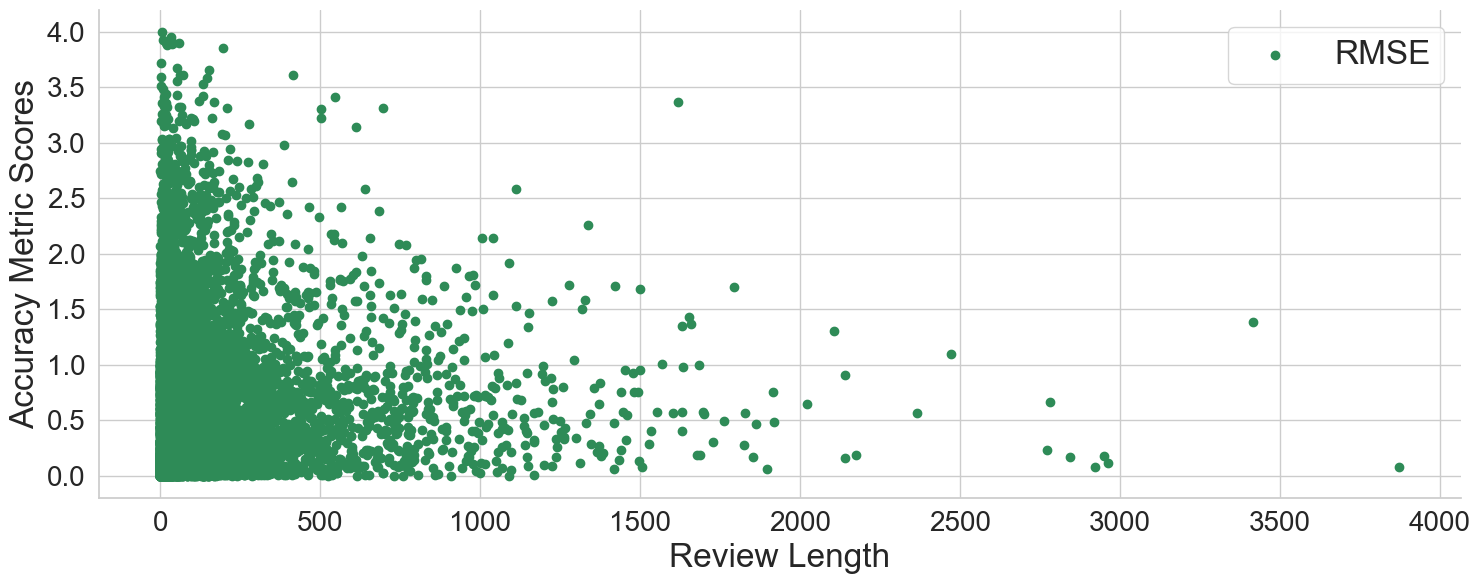

In [32]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Create a colormap for different accuracy metrics
colors = {'RMSE': 'seagreen'}

# 4. Visualize the Results: Plot the accuracy metrics (RMSE, MSE, MAE) against the number of rated items for each group.
# Plot number of rated items vs MAE, MSE, RMSE scatter plot
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(15, 6))

# Iterate over each accuracy metric
for metric in ['RMSE']:
    plt.scatter(merged['review_length'], merged[metric], c=colors[metric], label=metric)

plt.xlabel('Review Length', fontsize=24)
plt.ylabel('Accuracy Metric Scores', fontsize=24)
plt.legend(fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
plt.tight_layout()
plt.savefig("/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Final Writing/Figures/ncf_length_ratings_metrics.pdf")
plt.grid(True)
plt.show()

In [92]:
merged['review_length'].describe()

count    11004.000000
mean       113.130316
std        228.097073
min          1.000000
25%          6.000000
50%         31.000000
75%        118.000000
max       3872.000000
Name: review_length, dtype: float64

In [94]:
# see summary statistics for each group
tab = merged.groupby('group').agg({'MAE': ['mean'], 'MSE': ['mean'], 'RMSE': ['mean',]}).round(3)
display(tab)
tab['quartiles'] = ['0-6', '7-31', '32-118', '118-' ]
tab = tab[['quartiles', 'MAE', 'MSE', 'RMSE']]

import tabulate
latex_table = tabulate.tabulate(tab, headers='keys', tablefmt='latex_raw', showindex=False)
print(latex_table)


,MAE,MSE,RMSE
,mean,mean,mean
group,,,
Low,0.262,0.276,0.262
Medium,0.443,0.585,0.443
High,0.600,0.808,0.600
Very High,0.682,0.878,0.682


\begin{tabular}{lrrr}
\hline
 ('quartiles', '')   &   ('MAE', 'mean') &   ('MSE', 'mean') &   ('RMSE', 'mean') \\
\hline
 0-6                 &             0.262 &             0.276 &              0.262 \\
 7-31                &             0.443 &             0.585 &              0.443 \\
 32-118              &             0.6   &             0.808 &              0.6   \\
 118-                &             0.682 &             0.878 &              0.682 \\
\hline
\end{tabular}


In [55]:
# get mean rmse for each group
display(merged.groupby('group').agg({'MAE': ['mean'], 'MSE': ['mean'], 'RMSE': ['mean']}))

# apply anova test
import scipy.stats as stats
f_val, p_val = stats.f_oneway(merged[merged['group'] == 'Low']['RMSE'], merged[merged['group'] == 'Medium']['RMSE'], merged[merged['group'] == 'High']['RMSE'], merged[merged['group'] == 'Very High']['RMSE'])
print(f'F-Value: {f_val}')
print(f'P-Value: {p_val}')

# apply post-hoc test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(merged['RMSE'], merged['group'])
result = mc.tukeyhsd()
print(result)

MAE                 MSE                RMSE          
               mean       std      mean       std      mean       std
group                                                                
Low        0.346575  0.398803  0.279103  0.852480  0.346575  0.398803
Medium     0.525583  0.546542  0.574832  1.334484  0.525583  0.546542
High       0.655118  0.589329  0.776362  1.507023  0.655118  0.589329
Very High  0.705245  0.568950  0.820956  1.404352  0.705245  0.568950

F-Value: 258.44368222330866
P-Value: 4.3657602020545783e-162


  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj   lower   upper  reject
-------------------------------------------------------
  High       Low  -0.3085    0.0 -0.3448 -0.2723   True
  High    Medium  -0.1295    0.0 -0.1667 -0.0924   True
  High Very High   0.0501 0.0026  0.0134  0.0868   True
   Low    Medium    0.179    0.0  0.1423  0.2157   True
   Low Very High   0.3587    0.0  0.3224  0.3949   True
Medium Very High   0.1797    0.0  0.1425  0.2168   True
-------------------------------------------------------


## Model 3: Ratings + Reviews + Sentiments 

In [63]:
# load data
# amz_data = pd.read_csv(r'C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\Data\set2_data_modelling.csv')
amz_data = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/set3_data_modelling.csv')
text_embeddings = pd.read_csv(r'/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/NCF Data/text_embeddings.csv')
display(amz_data.head())

# print details
print('Number of Rows: ', amz_data.shape[0])
print('Number of Columns: ', amz_data.shape[1])
print('Number of Unique Users: ', len(amz_data['reviewerID'].unique()))
print('Number of Unique Products: ', len(amz_data['asin'].unique()))


# Creating User Item Matrix =====================================================
# create user-item matrix
data = amz_data.pivot_table(index='reviewerID', columns='asin', values='overall')
print("\n\nUser-Item Matrix")
display(data.head())

,reviewerID,reviewTime,asin,overall,reviewText,stemmed_words_revText,lemmatised_reviewText,filtered_tokens_revText,sentiments_afinn,sentiments_bing,sentiments_vader
0,AQ8OO59DJFJNZ,2018-01-05,0767834739,5.0,wonderful movie,wonder movi,wonderful movie,wonderful movie,4,1,0.5719
1,A244CRJ2QSVLZ4,2008-01-29,0767834739,5.0,resident evil is a great science fictionhorror...,resid evil great scienc fictionhorror hybrid p...,resident evil great science fictionhorror hybr...,resident evil great science fictionhorror hybr...,-12,-5,-0.9455
2,A1VCLTAGM5RLND,2005-07-23,0767834739,5.0,i this movie has people living and working und...,movi peopl live work underground place call hi...,movie people living working underground place ...,movie people living working underground place ...,-1,0,-0.1806
3,A119Q9NFGVOEJZ,2016-02-13,0767834739,5.0,every single video game based movie from the s...,everi singl video game base movi super mario b...,every single video game based movie super mari...,every single video game based movie super mari...,18,6,0.9846
4,A1RP6YCOS5VJ5I,2006-09-26,0767834739,5.0,i think that i like this movie more than the o...,think like movi origin origin still great real...,think like movie original original still great...,think like movie original original still great...,29,10,0.9951


Number of Rows:  83139
Number of Columns:  11
Number of Unique Users:  3668
Number of Unique Products:  3249


User-Item Matrix


asin,0767834739,7799146915,B00000DMAT,B00000DMAX,B00000DMB3,B00000F1GM,B00000I1BJ,B00000I1BY,B00000ID61,B00000INR2,...,B01H353FLA,B01H353HUY,B01H3VFR6U,B01H5GB8ZW,B01H6OXQFS,B01H9SH2LU,B01HGBAFNC,B01HHVVLGQ,B01HHVWWMI,B01HIZF7XE
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100RH4M1W1DF0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
A1027EV8A9PV1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103KKI1Y4TFNQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1047P9FLHTDZJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Word Embeddings

In [64]:
# import tensorflow as tf
# import tensorflow_hub as hub

# # load the model for sentence embeddings
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
# sent_model = hub.load(module_url)
# print(f"Module {module_url} loaded")

# # Embedding review text
# print("Applying the Universal Sentence Encoder on the review text...")
# review_text = amz_data['reviewText']  # Replace with your actual column name
# text_embeddings = sent_model(review_text)
# print("Review text embeddings generated!")
# print(f"Shape of Text Embeddings: {text_embeddings.shape}")

# # attach embeddings to dataframe
# text_embeddings = text_embeddings.numpy()
# text_embeddings = pd.DataFrame(text_embeddings)
# text_embeddings['revText'] = amz_data['reviewText']
# text_embeddings['asin'] = amz_data['asin']
# text_embeddings['reviewerID'] = amz_data['reviewerID']
display(text_embeddings.head(4))

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,revText,asin,reviewerID
0,-0.011411,0.012732,0.012249,-0.029770,0.032968,0.066360,-0.015612,-0.003035,-0.016978,0.029414,...,0.062207,-0.035347,0.011524,-0.036790,-0.030792,0.104588,0.000913,wonderful movie,0767834739,AQ8OO59DJFJNZ
1,0.016304,0.052245,-0.044929,-0.003093,0.030458,-0.015125,0.063519,-0.023906,0.013280,-0.034587,...,-0.061882,-0.062525,-0.012602,-0.040133,-0.000692,0.068579,0.023263,resident evil is a great science fictionhorror...,0767834739,A244CRJ2QSVLZ4
2,0.003858,0.014974,0.003381,-0.023209,0.053806,-0.059621,0.050380,-0.010782,-0.069886,-0.072230,...,0.004721,-0.043190,-0.042796,0.008850,-0.054297,0.075987,0.062721,i this movie has people living and working und...,0767834739,A1VCLTAGM5RLND
3,-0.003534,-0.056638,-0.049522,-0.006381,0.007624,0.006230,0.037928,-0.059353,-0.064795,-0.009551,...,0.058787,-0.064053,-0.006464,0.064920,-0.062360,0.065526,-0.062345,every single video game based movie from the s...,0767834739,A119Q9NFGVOEJZ


#### Sentiment Scores

In [65]:
sentiments = amz_data[['reviewerID', 'asin','sentiments_vader']]
sentiments.columns = ['reviewerID', 'asin', 'sentiments']
display(sentiments.head(3))

,reviewerID,asin,sentiments
0,AQ8OO59DJFJNZ,0767834739,0.5719
1,A244CRJ2QSVLZ4,0767834739,-0.9455
2,A1VCLTAGM5RLND,0767834739,-0.1806


In [66]:
# DATA PREP ====================================

# create a copy of the original matrix to store hidden ratings
x_hidden = data.copy()
indices_tracker = []

# number of products to hide for each user
N = 3

# identifies rated items and randomly selects N products to hide ratings for each user
np.random.seed(2207)  # You can use any integer value as the seed
for user_id in range(x_hidden.shape[0]):
    rated_products = np.where(x_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_products, N, replace=False)
    indices_tracker.append(hidden_indices)
    x_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = x_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'product', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

In [67]:
# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = x_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='product', value_name='rating')


# change rows with hidden ratings to NaN
data_hidden.iloc[indices_hidden, 2] = np.nan

# rename columns
data_hidden.columns = ['user', 'product', 'rating']

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# add sentiments
data_hidden = pd.merge(data_hidden, sentiments, how='outer', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
data_hidden.drop(['asin','reviewerID'], axis=1, inplace=True)

# add text embeddings to the data (match user and product to the embeddings)
data_hidden = pd.merge(data_hidden, text_embeddings, how='outer', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
data_hidden.drop(['revText', 'asin','reviewerID'], axis=1, inplace=True)

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# Convert user and item to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['product'] = data_hidden['product'].astype('category')

# see what the data looks like
display(data_hidden.head(4))
print("Data is in format: user, product, rating, sentiments, text embeddings.\nIt is ready to be partitioned into training and testing sets.")

,user,product,rating,sentiments,0,1,2,3,4,5,...,502,503,504,505,506,507,508,509,510,511
0,A100RH4M1W1DF0,B001NJJOCW,5.0,0.6369,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
1,A100RH4M1W1DF0,B003SIOXTA,5.0,0.6369,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
2,A100RH4M1W1DF0,B003ZXCAAC,5.0,0.5859,-0.009528,-0.077318,-0.078732,-0.022566,0.020784,0.040238,...,-0.001551,-0.000948,-0.083168,0.060334,0.077315,-0.022964,0.076978,-0.033895,0.033755,0.004203
3,A100RH4M1W1DF0,B00AA8WPGY,5.0,-0.7269,-0.041756,-0.010512,0.014876,-0.018273,-0.043437,-0.015833,...,0.008394,0.021828,0.048689,-0.000628,-0.007572,0.048054,0.008952,0.060675,0.000830,0.021475


Data is in format: user, product, rating, sentiments, text embeddings.
It is ready to be partitioned into training and testing sets.


#### Train and Test Splits

In [68]:
# TEST AND TRAIN DATA ====================================

# Prepare the data - trining
train_x = data_hidden[['user', 'product']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

# add text embeddings to the training data (merge on index)
train_x = pd.merge(train_x, data_hidden, how='outer', left_index=True, right_index=True)
train_x.drop(['user_y', 'product_y', 'rating'], axis=1, inplace=True)
train_x.rename(columns={'user_x': 'user', 'product_x': 'product'}, inplace=True)
train_x


# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='product', value_name='rating')
copy.columns = ['user', 'product', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]

# add sentiments to the testing data
test_x = pd.merge(test_x, sentiments, how='left', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
test_x.drop(['asin','reviewerID'], axis=1, inplace=True)

# add text embeddings to the testing data (merge on user and product)
test_x = pd.merge(test_x, text_embeddings, how='left', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
test_x.drop(['revText', 'asin','reviewerID'], axis=1, inplace=True)
test_x['user'] = test_x['user'].astype('category')
test_x['product'] = test_x['product'].astype('category')

# use cat codes to convert to numerical (for user and product)
test_x['user'] = test_x['user'].cat.codes
test_x['product'] = test_x['product'].cat.codes
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

# show the data
print("Training Data")
display(train_x.head(3))

print("\nTesting Data")
display(test_x.head(3))


Training Data


,user,product,sentiments,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,0,993,0.6369,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
1,0,1189,0.6369,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
2,0,1203,0.5859,-0.009528,-0.077318,-0.078732,-0.022566,0.020784,0.040238,0.036082,...,-0.001551,-0.000948,-0.083168,0.060334,0.077315,-0.022964,0.076978,-0.033895,0.033755,0.004203



Testing Data


,user,product,sentiments,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,174,0,0.9907,0.039119,-0.059384,-0.027734,-0.032066,0.045529,0.051033,0.016597,...,-0.011423,-0.062120,0.006031,-0.036203,-0.060012,0.018534,0.053185,0.039681,0.062120,0.057558
1,805,1,0.8604,0.033977,-0.053225,-0.040635,-0.042631,0.037649,-0.014275,0.010381,...,-0.019601,-0.061564,0.051966,0.011331,-0.046066,0.058120,0.050817,0.058296,0.061771,0.019092
2,1201,1,0.9574,0.045144,-0.061331,-0.039053,0.068657,0.053297,-0.012607,-0.045700,...,-0.004607,-0.074282,-0.033336,-0.017320,0.036439,0.029585,-0.000270,0.003543,0.074316,0.049292


#### NCF Model with Reviews + Sentiments

In [69]:
# Function to train a neural network model for collaborative filtering with text embeddings
def train_model_3(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2_reg, train_x, train_y, text_embedding_dim, seed=2207, train_plot=True, callback=True):
    np.random.seed(seed)

    # Inputs
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')
    text_input = Input(shape=(text_embedding_dim,), dtype='float32', name='text_input') 
    sentiment_input = Input(shape=(1,), dtype='float32', name='sentiment_input')  # Sentiment scores

    # Embeddings
    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    product_embedding = Embedding(input_dim=len(data_hidden['product'].cat.categories), output_dim=50, name='product_embedding')(product_input)

    # Flatten
    user_vecs = Flatten()(user_embedding)
    product_vecs = Flatten()(product_embedding)

    # Concatenate user, product, and text embeddings
    input_vecs = Concatenate()([user_vecs, product_vecs, sentiment_input, text_input])

    # Add dense layers
    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu', kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu', kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout)(x)
    y = Dense(1)(x)

    # Compile and train the model
    model = Model(inputs=[user_input, product_input, sentiment_input, text_input], outputs=y)

    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    # Define early stopping
    if callback:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


    # Train the model
    if callback:
        history = model.fit([train_x['user'], train_x['product'],  train_x.iloc[:, 3:], train_x['sentiments']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])
    else:
        history = model.fit([train_x['user'], train_x['product'],  train_x.iloc[:, 3:], train_x['sentiments']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    # Plot training & validation loss values
    if train_plot:
        # Plot training & validation loss values
        plt.figure(figsize=(15, 8))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        # plt.title(f'Model loss for Architecture: {optimizer} optimizer, {n_layers} layers, {n_nodes} nodes, {epochs} epochs, {learning_rate} learning rate, {batch_size} batch size')
        plt.ylabel('Loss', fontsize=40)
        plt.xlabel('Epoch', fontsize = 40)
        plt.xticks(fontsize=36)
        plt.yticks(fontsize=36)
        plt.legend(loc='upper right', fontsize=40)
        plt.tight_layout()
        plt.savefig("/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Final Writing/Figures/ncf_training_3.pdf")
        plt.show()
    
    return model, history


Epoch 1/50
508/508 [==============================] - 10s 15ms/step - loss: 0.6998 - val_loss: 0.0577
Epoch 2/50
508/508 [==============================] - 8s 15ms/step - loss: 0.0634 - val_loss: 0.0572
Epoch 3/50
508/508 [==============================] - 7s 14ms/step - loss: 0.0564 - val_loss: 0.0571
Epoch 4/50
508/508 [==============================] - 8s 16ms/step - loss: 0.0523 - val_loss: 0.0550
Epoch 5/50
508/508 [==============================] - 10s 20ms/step - loss: 0.0495 - val_loss: 0.0537
Epoch 6/50
508/508 [==============================] - 10s 19ms/step - loss: 0.0474 - val_loss: 0.0539
Epoch 7/50
508/508 [==============================] - 7s 14ms/step - loss: 0.0465 - val_loss: 0.0540
Epoch 8/50
508/508 [==============================] - 7s 14ms/step - loss: 0.0456 - val_loss: 0.0546
Epoch 9/50
508/508 [==============================] - 7s 14ms/step - loss: 0.0447 - val_loss: 0.0520
Epoch 10/50
508/508 [==============================] - 7s 14ms/step - loss: 0.0442 - val

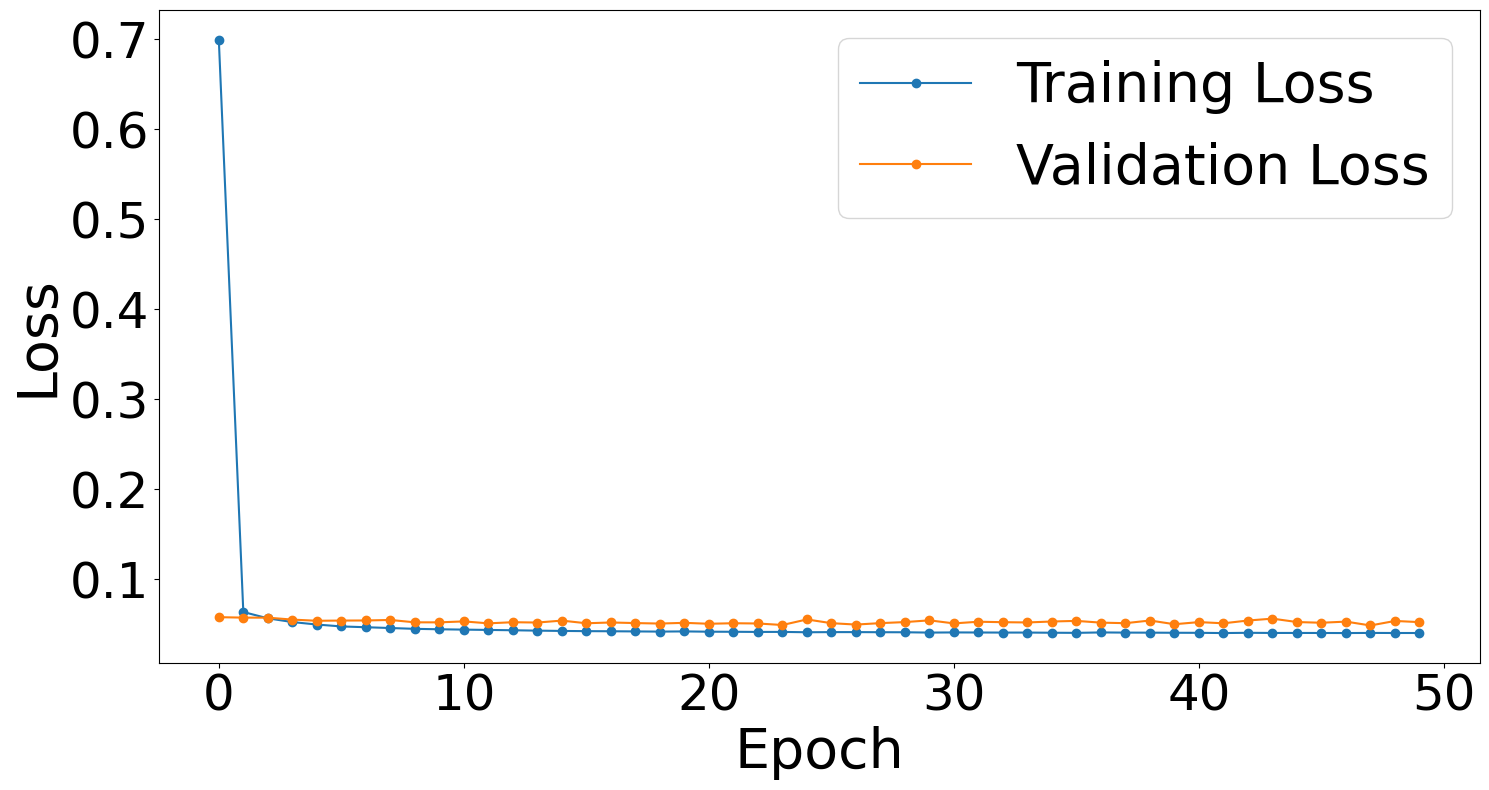

In [70]:
# Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
# print("Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
# model, history = train_model_3(n_layers=2, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01,  seed=10, train_plot=False, callback=True)

model, history = train_model_3(n_layers=3, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=128, dropout=0.5, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=10, train_plot=True, callback=False, text_embedding_dim = text_embeddings.shape[1]-3)

# # Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
# print("Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
# model2, history2 = train_model_3(n_layers=3, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01, seed=10, train_plot=False, callback=True)

# # Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
# print("Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
# model3, history3 = train_model_3(n_layers=4, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01, seed=10, train_plot=False, callback=True)

# # Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
# print("Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
# model4, history4 = train_model_3(n_layers=5, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01, seed=10, train_plot=False, callback=True)

#### Training Results

In [33]:
# Which model had lowest validation loss?
print("Model 1 Validation Loss: ", min(history.history['val_loss']))
print("Model 2 Validation Loss: ", min(history2.history['val_loss']))
print("Model 3 Validation Loss: ", min(history3.history['val_loss']))
print("Model 4 Validation Loss: ", min(history4.history['val_loss']))

Model 1 Validation Loss:  0.0439918115735054
Model 2 Validation Loss:  0.049126289784908295
Model 3 Validation Loss:  0.05599662661552429
Model 4 Validation Loss:  0.055998094379901886


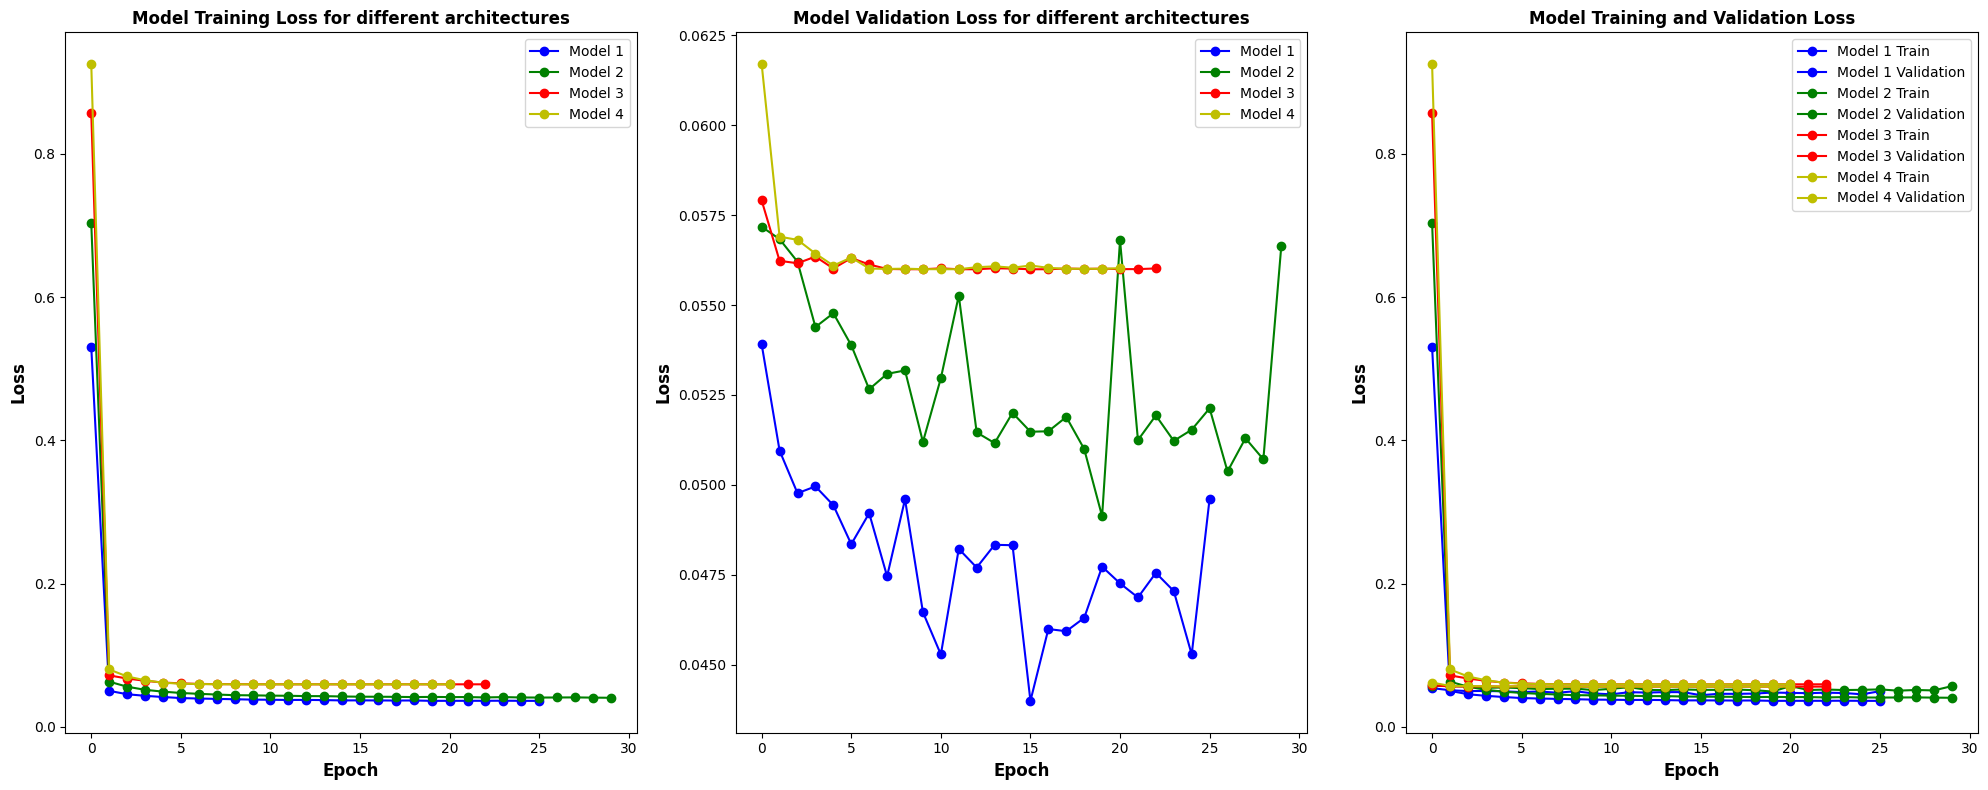

Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size


In [34]:
# Visualize training and validation loss for all models
plt.figure(figsize=(20, 8))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Training Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Validation Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['val_loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['val_loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['val_loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['val_loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Validation Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Plot validation and training loss on same plot
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Model 1 Train', marker='o', color = 'b')
plt.plot(history.history['val_loss'], label='Model 1 Validation', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2 Train', marker='o', color = 'g')
plt.plot(history2.history['val_loss'], label='Model 2 Validation', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3 Train', marker='o', color = 'r')
plt.plot(history3.history['val_loss'], label='Model 3 Validation', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4 Train', marker='o', color = 'y')
plt.plot(history4.history['val_loss'], label='Model 4 Validation', marker='o', color = 'y')
plt.title('Model Training and Validation Loss', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print models
print("Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")

#### Hyperparamaeter Tuning

In [ ]:
import itertools

# Grid Search Parameters
n_layers = [1,2,3,6,8] 
n_nodes = [128,256,512,1024] 
optimizer = ['adam', 'sgd']
epochs = [50,150,300] 
learning_rate = [0.001, 0.01,  0.0001] 
batch_size = [32,64,128] 
dropout = [0, 0.01, 0.05, 0.08]
l2 = [0.01, 0.001, 0.0001]
print(f"Number of combinations: {len(n_layers) * len(n_nodes) * len(optimizer) * len(epochs) * len(learning_rate) * len(batch_size)* len(dropout)* len(l2)}")

def grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2, train_x, train_y):
    # Initialize best parameters and best model variables
    best_params = None
    best_model = None
    best_score = None

    # Generate all possible combinations of hyperparameters
    param_combinations = itertools.product(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2)

    # Loop through all combinations
    for combination in param_combinations:
        # Unpack the combination
        n_layer, n_node, opt, epoch, lr, bs, dropout, l2 = combination

        # Train the model
        model, history = train_model_2(n_layer, n_node, opt, epoch, lr, bs, dropout, l2, train_x, train_y, train_plot=False, seed=10, text_embedding_dim = text_embeddings.shape[1]-3, callback=True)

        # Evaluate the model - min val loss
        min_loss = min(history.history['val_loss'])
        
        # Check if this model is better than the previous best
        if best_score is None or min_loss < best_score:
            best_score = min_loss
            best_params = combination
            best_model = model

    return best_params, best_model


# run grid search
best_params, best_model = grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2, train_x, train_y)
print(f"Best Parameters: {best_params}")

Epoch 1/200
508/508 [==============================] - 5s 8ms/step - loss: 0.5154 - val_loss: 0.0515
Epoch 2/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0489 - val_loss: 0.0504
Epoch 3/200
508/508 [==============================] - 3s 7ms/step - loss: 0.0447 - val_loss: 0.0488
Epoch 4/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0425 - val_loss: 0.0482
Epoch 5/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0409 - val_loss: 0.0474
Epoch 6/200
508/508 [==============================] - 4s 8ms/step - loss: 0.0400 - val_loss: 0.0483
Epoch 7/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0390 - val_loss: 0.0475
Epoch 8/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0386 - val_loss: 0.0480
Epoch 9/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0382 - val_loss: 0.0472
Epoch 10/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0380 - val_lo

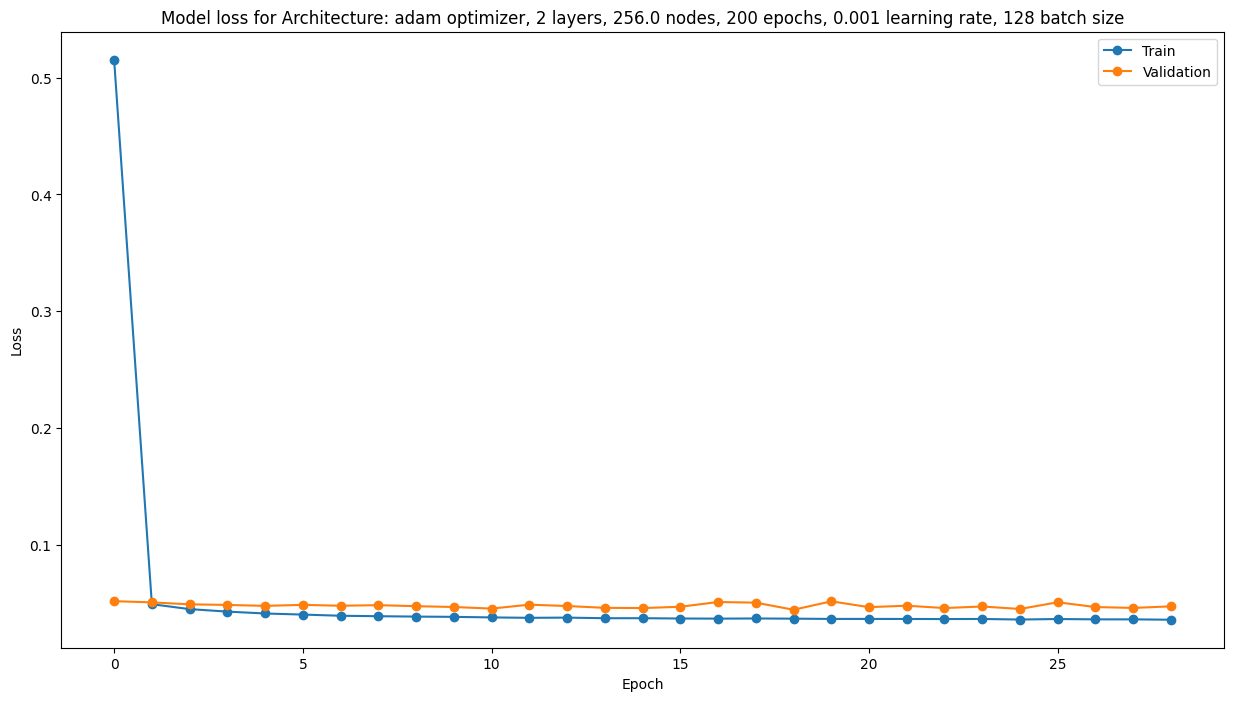

In [37]:
# fit best model 
best_model, history = train_model_3(n_layers=best_params[0], n_nodes=best_params[1], optimizer=best_params[2], epochs=best_params[3], learning_rate=best_params[4], batch_size=best_params[5], dropout=best_params[6], l2_reg=best_params[7], train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, train_plot=True, callback=True, seed=10)

#### Evaluation

In [38]:
# MODEL EVALUATION ====================================
# Predict the ratings
y_pred = best_model.predict([test_x['user'], test_x['product'], test_x.iloc[:, 3:], test_x['sentiments']])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# save results to csv
results = pd.DataFrame({'MAE': [mae.round(3)], 'MSE': [mse.round(3)], 'RMSE': [rmse.round(3)]})
results.to_csv("Data/Results/NCF_results_3.csv", index=False)
results

344/344 [==============================] - 1s 2ms/step

Rating Metrics
Mean Absolute Error (MAE): 0.5290225445899215
Mean Squared Error (MSE): 0.6065956156389717
Root Mean Squared Error (RMSE): 0.7788424844851312


,MAE,MSE,RMSE
0,0.529,0.607,0.779


## Model 4: Naive Model

We want to build a **naive benchmark model to compare with our NCF model**. The benchmark model will predict the rating of a user-item pair as:

1. the most popular rating in the training set. For example, if the most popular rating in the training set is 4, then the benchmark model will predict the rating of all user-item pairs as 4.

***TLDR***: The benchmark model, which predicts a constant value (5) for all ratings, outperforms the NCF model in terms of rating metrics and some classification metrics. The NCF model, while providing reasonable results, might need further optimization or tuning to improve its performance, especially in terms of rating prediction.


In [39]:
# Benchmark Model 1 (make it all 5s) ====================================
benchmark_results_1 = predicted_ratings_array.copy()
benchmark_results_1.fill(5)

In [40]:
# evaluate benchmark model 1 ====================================
predicted_ratings_array = benchmark_results_1

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# save results to csv
results = pd.DataFrame({'MAE': [mae.round(3)], 'MSE': [mse.round(3)], 'RMSE': [rmse.round(3)]})
results.to_csv("Data/Results/NCF_results_benchmark.csv", index=False)
results


Rating Metrics
Mean Absolute Error (MAE): 0.5822428207924392
Mean Squared Error (MSE): 1.269629225736096
Root Mean Squared Error (RMSE): 1.1267782504717136


,MAE,MSE,RMSE
0,0.582,1.27,1.127
